# Algorithmic Fairness & Interpretability

## Group 6
Tanmay KALE, Ameya KULKARNI, Felipe MANSILLA, Khushi VERMA, Qiling ZHU

M2, Data Science & AI for Business

## Table of Contents
- [Exercise 01: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.](#exercise-01)
    - [Surrogate Model: Logistic Regression](#surrogate-model-logistic-regression)
    - [Surrogate Model: Linear Regression](#surrogate-model-linear-regression)
    - [Surrogate Model: L1 Logistic Regression](#surrogate-model-l1-logistic-regression)
    - [Surrogate Model: Decision Tree](#surrogate-model-decision-tree)
- [Exercise 02: Estimate your own black-box machine learning model forecasting default.](#exercise-02)
    - [EDA](#eda)
    - [Modeling](#modeling)
- [Exercise 03: Analyze the forecasting performance of your own model](#exercise-03)
- [Exercise 04: Global interpretability: Implement one or two surrogate model(s) to interpret your own model](#exercise-04)
    - [Surrogate Model for our Own Black-Box Model: Logistic Regression](#surrogate-model-for-our-own-black-box-model-logistic-regression)
    - [Surrogate Model for Own Blackbox: Linear Regression](#surrogate-model-for-own-blackbox-linear-regression)
    - [Surrogate Model for Own Blackbox: L1 Logistic Regression](#surrogate-model-for-own-blackbox-l1-logistic-regression)
    - [Surrogate Model for Own Blackbox: Decision Tree](#surrogate-model-for-own-blackbox-decision-tree)
- [Exercise 05: Global interpretability: Implement the PDP method to interpret your own model.](#exercise-05)
- [Exercise 06: Local interpretability: Implement the ICE method to interpret your own model.](#exercise-06)
- [Exercise 07: Local interpretability: Implement the SHAP method to interpret your own model](#exercise-07)
- [Exercise 08: Performance interpretability: Implement the permutation importance to interpret your own model.](#exercise-08)
- [Exercise 09: Fairness: Assess the fiarness of your own model with respect to age.](#exercise-09)
    - [Statistical Parity](#statistical-parity)
    - [Conditional Statistical Parity](#conditional-statistical-parity)
- [Exercise 10: FPDP](#exercise-10)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    r2_score,
    balanced_accuracy_score,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    auc,
    make_scorer,
)
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeRegressor

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTENC

from scipy.stats import chi2_contingency, norm
import optuna
import shap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Exercise 01: 
## Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

### Surrogate Model: Logistic Regression

In [3]:
df = pd.read_excel("../Data/dataproject2024.xlsx", sheet_name="Sheet1")

# Define feature set (X) and target (y)
X = df.drop(
    columns=["ID", "Pred_default (y_hat)", "Default (y)", "PD", "Group"]
)  # Dropping non-feature columns
y = df["Pred_default (y_hat)"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Performance metrics
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


# Print the metrics
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", classification_rep)

# Inspect feature importance (coefficients in logistic regression)
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": log_reg.coef_[0]}
).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):\n", feature_importance)


Balanced Accuracy: 0.63
F1 Score: 0.40

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      1313
           1       0.64      0.29      0.40       173

    accuracy                           0.90      1486
   macro avg       0.78      0.63      0.67      1486
weighted avg       0.88      0.90      0.88      1486


Feature Importance (Logistic Regression Coefficients):
            Feature  Coefficient
7     Credit event     2.865588
6  Monthly payment     0.859944
4     Down payment     0.279550
5    Loan duration     0.010544
3   Funding amount     0.000492
2        Car price    -0.000422
1              Age    -0.019250
0       Job tenure    -0.102204
9        Homeowner    -0.745605
8          Married    -1.067138


### Surrogate Model: Linear Regression

In [4]:
# Define feature set (X) and target (y, in this case PD)
X = df.drop(
    columns=["ID", "PD", "Default (y)", "Pred_default (y_hat)", "Group"]
)  # Dropping non-feature columns
y = df["PD"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_prob = lin_reg.predict(X_test)

y_test_pred = np.where(y_test > 0.5, 1, 0)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Performance metrics for regression
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred_prob)

balanced_accuracy = balanced_accuracy_score(y_test_pred, y_pred)

# Print the metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": lin_reg.coef_}
).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Linear Regression Coefficients):\n", feature_importance)


Mean Squared Error: 0.0839
R^2 Score: 0.4233
Balanced Accuracy: 0.54

Feature Importance (Linear Regression Coefficients):
            Feature  Coefficient
7     Credit event     0.315471
6  Monthly payment     0.291974
4     Down payment     0.081968
5    Loan duration     0.001142
3   Funding amount     0.000026
2        Car price    -0.000021
1              Age    -0.001269
0       Job tenure    -0.002953
9        Homeowner    -0.064714
8          Married    -0.072892


### Surrogate Model: L1 Logistic Regression

In [5]:
X = df.drop(columns=["ID", "PD", "Default (y)", "Pred_default (y_hat)", "Group"])
y = df["Pred_default (y_hat)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(
    penalty="l1", solver="saga", C=1.0, max_iter=5000
)  # 'saga' solver supports L1 penalty
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy}")


Balanced Accuracy: 0.6359746245856244


In [6]:
feature_names = (
    X.columns
    if isinstance(X, pd.DataFrame)
    else [f"feature_{i}" for i in range(X.shape[1])]
)

# Extracting coefficients
coefficients = (
    model.coef_.flatten()
)  # Flatten in case of binary classification (1 class)

# Creating a DataFrame of feature names and their corresponding coefficients
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)

# Sorting by the absolute value of the coefficients (importance)
feature_importance["Importance"] = np.abs(feature_importance["Coefficient"])
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)


# Display the top features
print("\nFeature Importance (L1 Logistic Regression Coefficients):\n")
print(feature_importance)



Feature Importance (L1 Logistic Regression Coefficients):

           Feature  Coefficient  Importance
3   Funding amount     2.850502    2.850502
2        Car price    -2.526923    2.526923
0       Job tenure    -1.028962    1.028962
8          Married    -0.536742    0.536742
7     Credit event     0.442278    0.442278
9        Homeowner    -0.360317    0.360317
1              Age    -0.280930    0.280930
5    Loan duration     0.215502    0.215502
6  Monthly payment     0.116170    0.116170
4     Down payment     0.050129    0.050129


### Surrogate Model: Decision Tree

In [7]:
X = df.drop(columns=["ID", "PD", "Default (y)", "Pred_default (y_hat)", "Group"])
y = df["PD"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train a decision tree regressor as the surrogate model
surrogate_model = DecisionTreeRegressor(max_depth=4)
surrogate_model.fit(X_train, y_train)

# Make predictions with the surrogate model
y_pred_surrogate = surrogate_model.predict(X_test)


# Make predictions with the surrogate model
y_pred_surrogate = surrogate_model.predict(X_test)

# Define a threshold to convert regression output into binary classification (assuming PD is a binary outcome)
# For example, let's assume a threshold of 0.5
y_pred_classes = (y_pred_surrogate >= 0.5).astype(int)  # Convert predictions to 0 and 1

# Convert the actual target values to binary classes as well (assuming a threshold)
y_test_classes = (y_test >= 0.5).astype(int)

# Calculate accuracy (for binary classification)
balanced_accuracy = balanced_accuracy_score(y_test_classes, y_pred_classes)

# Calculate R-squared (for regression)
r2 = r2_score(y_test, y_pred_surrogate)

# Print the results
print(f"R-squared for the surrogate model: {r2}")
print(f"Balanced Accuracy for the surrogate model: {balanced_accuracy}")

R-squared for the surrogate model: 0.38722719401884775
Balanced Accuracy for the surrogate model: 0.5774681306411091


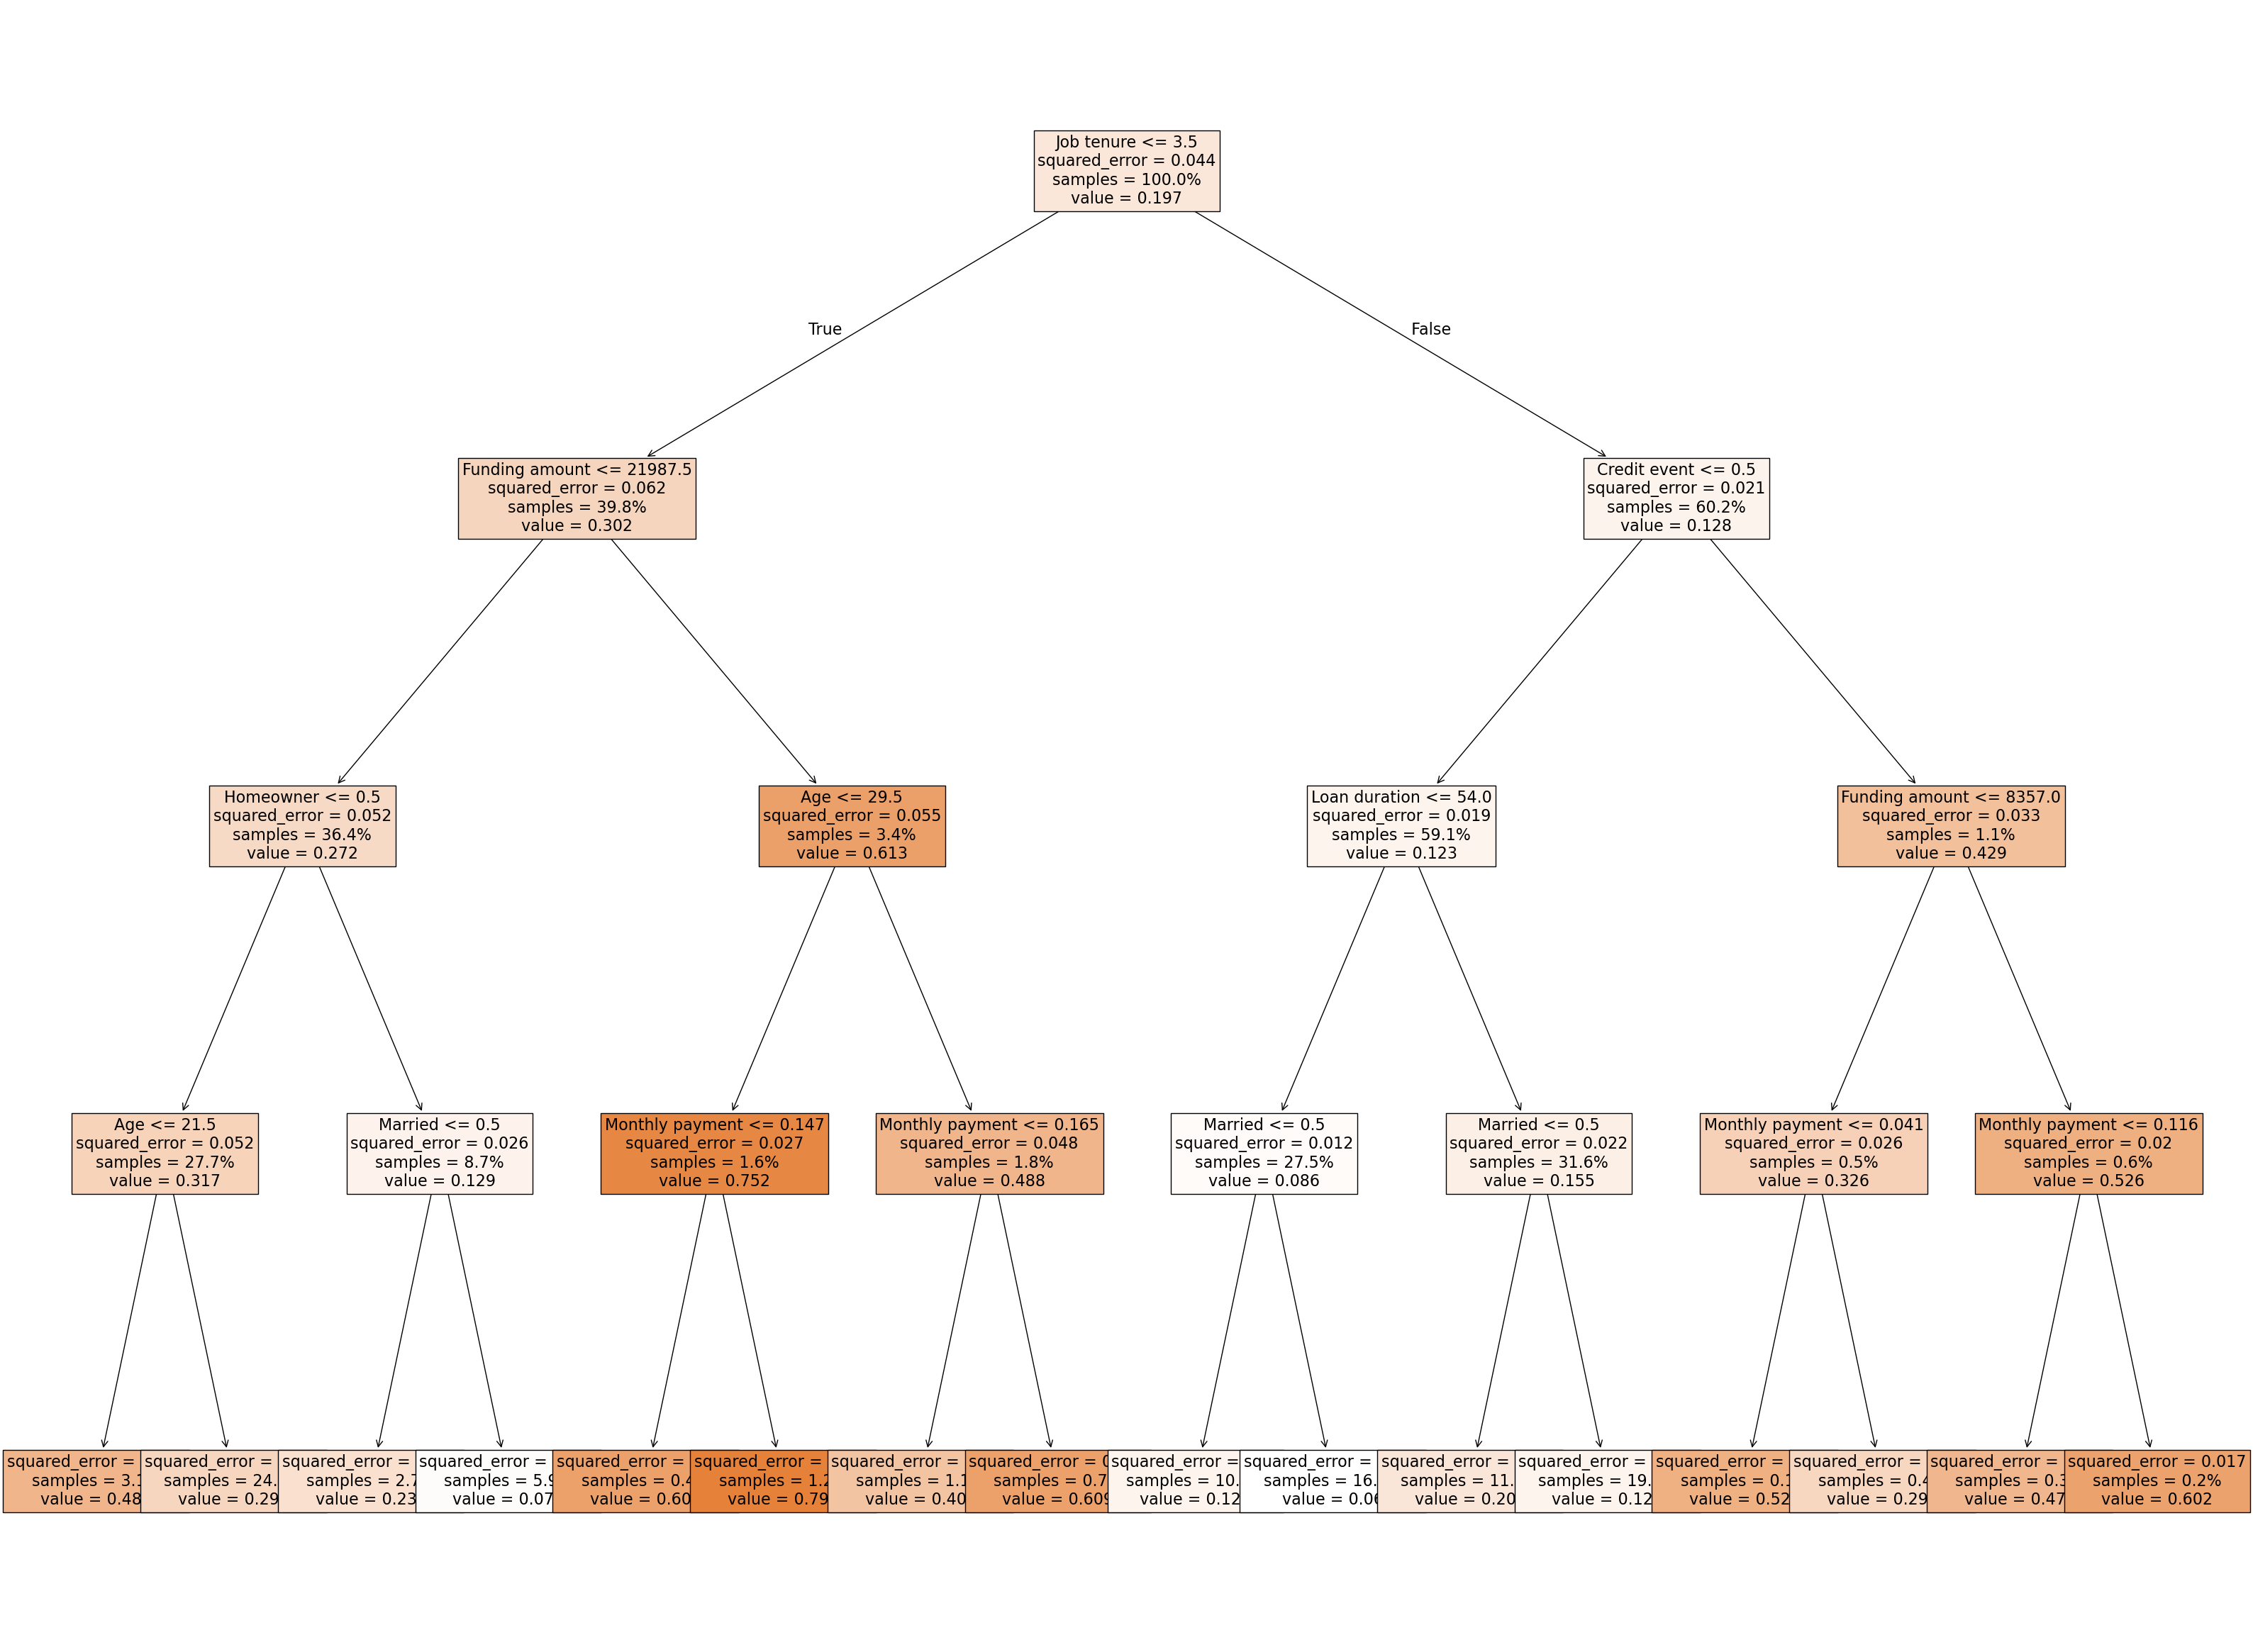

In [8]:
plt.figure(figsize=(40, 30), dpi=100)  # Larger figure size and higher dpi
plot_tree(
    surrogate_model,
    feature_names=X.columns,
    filled=True,
    fontsize=16,  # Slightly reduce font size for better fit
    proportion=True,
)
plt.show()


# Exercise 02: 
## Estimate your own black-box machine learning model forecasting default.

In [9]:
# Analyzing the performance of the existing black-box model

# Generate the classification report
report = classification_report(df["Default (y)"], df["Pred_default (y_hat)"])
print("Classification Report:\n", report)

# Calculate the balanced accuracy
balanced_acc = balanced_accuracy_score(df["Default (y)"], df["Pred_default (y_hat)"])
print("Balanced Accuracy:", balanced_acc)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      5945
           1       0.70      0.41      0.52      1485

    accuracy                           0.85      7430
   macro avg       0.78      0.68      0.71      7430
weighted avg       0.83      0.85      0.83      7430

Balanced Accuracy: 0.682846406311503


### EDA

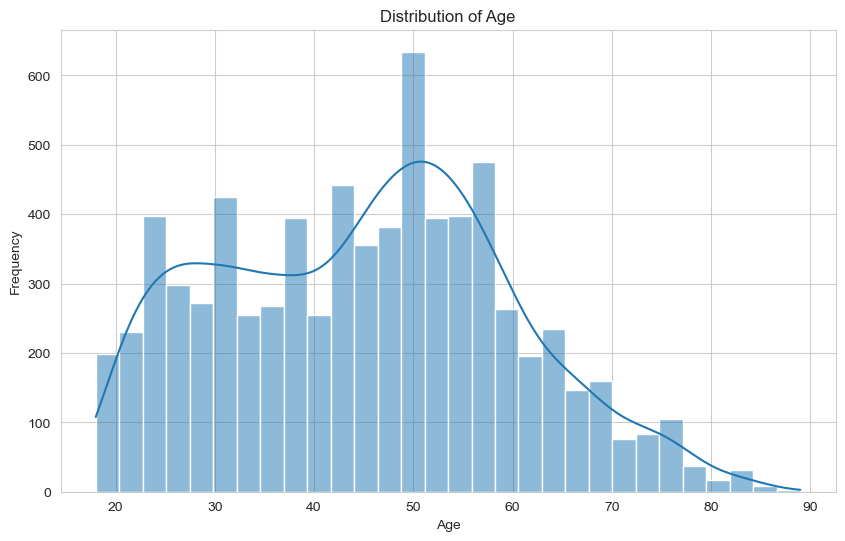

In [10]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.histplot(df["Age"], bins=30, kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


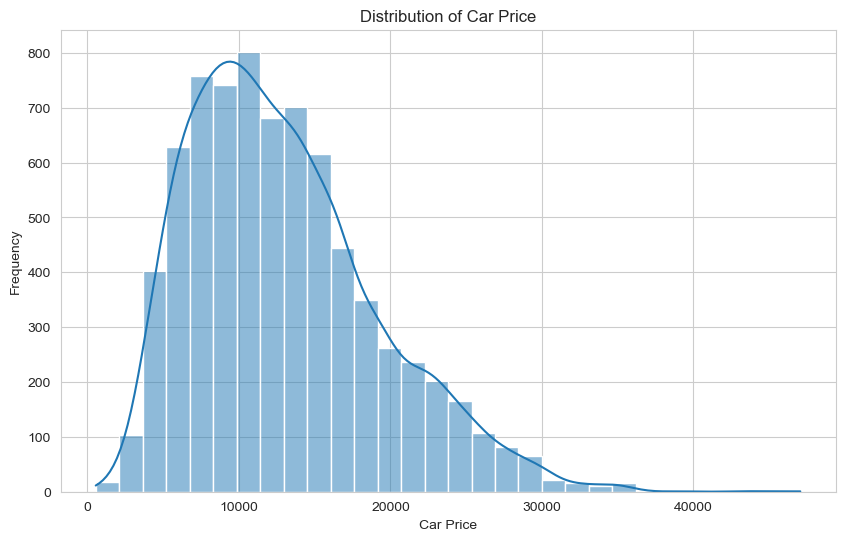

In [11]:
# Plot the distribution of 'Car price'
plt.figure(figsize=(10, 6))
sns.histplot(df["Car price"], bins=30, kde=True)
plt.title("Distribution of Car Price")
plt.xlabel("Car Price")
plt.ylabel("Frequency")
plt.show()


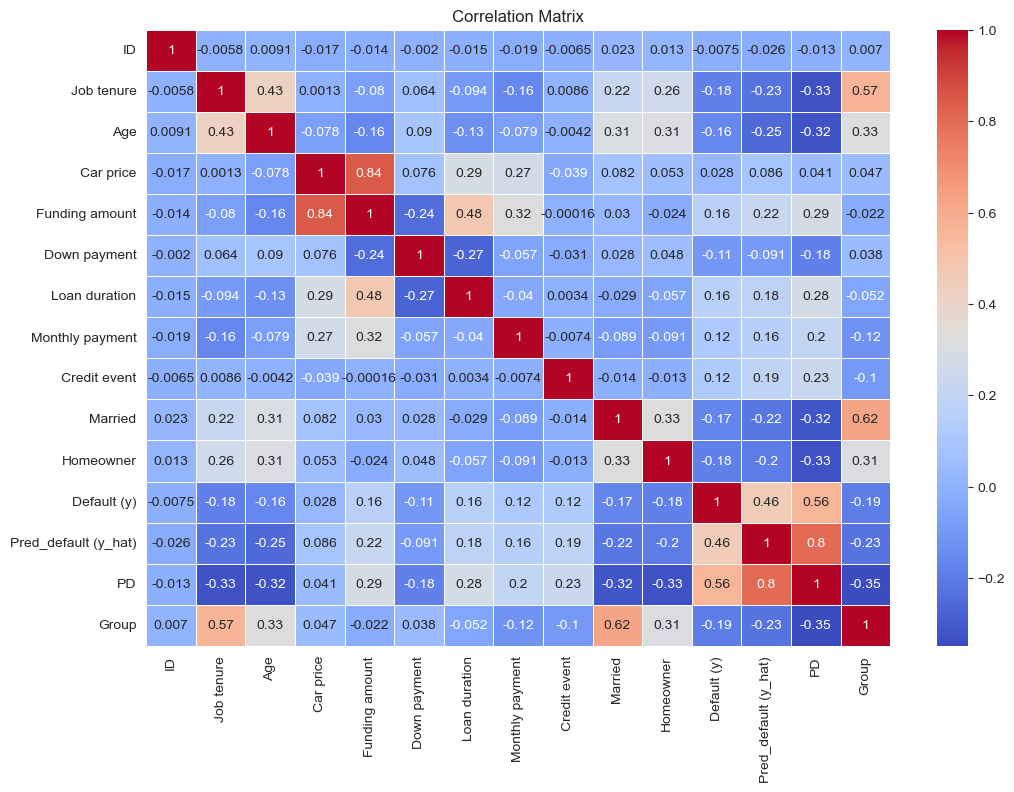

In [12]:
# Plot the correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


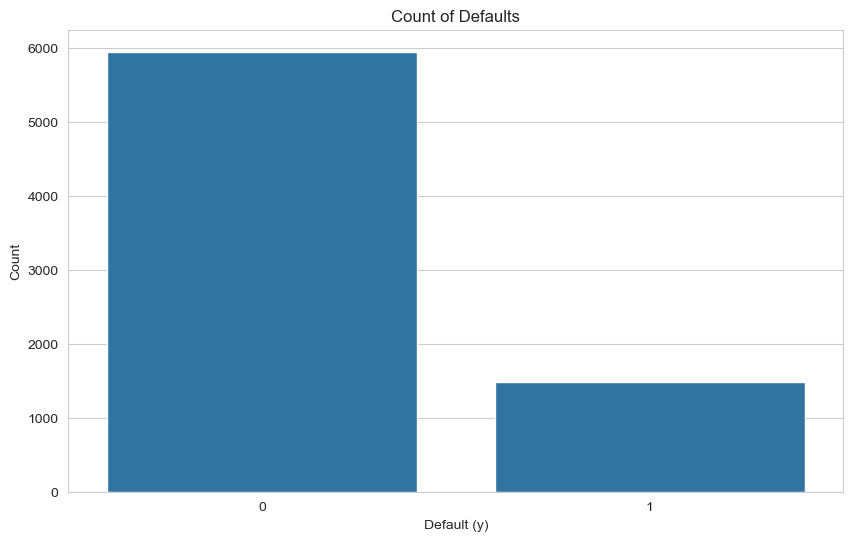

In [13]:
# Plot the count of defaults
plt.figure(figsize=(10, 6))
sns.countplot(x="Default (y)", data=df)
plt.title("Count of Defaults")
plt.xlabel("Default (y)")
plt.ylabel("Count")
plt.show()


In [14]:
# Check for null values by column
null_values = df.isnull().sum()
print(null_values)


ID                      0
Job tenure              0
Age                     0
Car price               0
Funding amount          0
Down payment            0
Loan duration           0
Monthly payment         0
Credit event            0
Married                 0
Homeowner               0
Default (y)             0
Pred_default (y_hat)    0
PD                      0
Group                   0
dtype: int64


### Modeling

In [15]:
# Define the feature matrix X and the target variable y
X = df.drop(columns=["Default (y)", "Pred_default (y_hat)", "PD", "Group", "ID"])
y = df["Default (y)"]

# Feature engineering

# Monthly payment to income ratio
X["Monthly payment to income ratio"] = X["Monthly payment"] / (
    X["Funding amount"] + 1e-9
)  # Adding a small value to avoid division by zero

# Loan to car price ratio
X["Loan to car price ratio"] = X["Funding amount"] / (
    X["Car price"] + 1e-9
)  # Adding a small value to avoid division by zero


# Interaction terms between job tenure, age, and monthly payment
X["Job tenure * Age"] = X["Job tenure"] * X["Age"]
X["Job tenure * Monthly payment"] = X["Job tenure"] * X["Monthly payment"]
X["Age * Monthly payment"] = X["Age"] * X["Monthly payment"]


# Display the first few rows of the updated DataFrame to verify
print(X.head())


   Job tenure  Age  Car price  Funding amount  Down payment  Loan duration  \
0          34   55       4875            3087             0             36   
1           5   29      13000           13000             0             60   
2          14   38      17190           14190             0             60   
3          16   37      22773           23568             0             48   
4           1   61       7700            8526             0             48   

   Monthly payment  Credit event  Married  Homeowner  \
0         0.047895             0        1          1   
1         0.091667             0        0          0   
2         0.088235             0        0          0   
3         0.110084             0        1          1   
4         0.123404             0        1          0   

   Monthly payment to income ratio  Loan to car price ratio  Job tenure * Age  \
0                         0.000016                 0.633231              1870   
1                         0.0000

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [17]:
smote = SMOTENC(categorical_features=[7, 8, 9])

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
def objective(trial):
    # Define the hyperparameters to tune
    hidden_layer_sizes = trial.suggest_categorical(
        "hidden_layer_sizes", [(50,), (100,), (100, 50), (100, 100)]
    )
    activation = trial.suggest_categorical(
        "activation", ["identity", "logistic", "tanh", "relu"]
    )
    solver = trial.suggest_categorical(
        "solver", ["sgd", "adam"]
    )  # Excluding lbfgs due to learning_rate
    alpha = trial.suggest_loguniform("alpha", 1e-5, 1e-1)
    learning_rate = trial.suggest_categorical(
        "learning_rate", ["constant", "invscaling", "adaptive"]
    )
    learning_rate_init = trial.suggest_loguniform("learning_rate_init", 1e-5, 1e-2)

    # Create the model with the suggested hyperparameters
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        alpha=alpha,
        learning_rate=learning_rate,
        learning_rate_init=learning_rate_init,
        max_iter=1000,
        random_state=42,
    )

    scaler = StandardScaler()

    pipeline = Pipeline([("scaler", scaler), ("model", model)])

    # Define the F1 scorer for cross-validation
    scoring = make_scorer(f1_score, pos_label=1)

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(
        pipeline, X_resampled, y_resampled, cv=5, scoring=scoring, n_jobs=-1
    )

    # Return the mean F1 score across the 5 folds
    return cv_scores.mean()


In [19]:
# # Create a study and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)

# # Print the best hyperparameters
# print("Best hyperparameters: ", study.best_params)


In [20]:
# best_params = study.best_params

# model = MLPClassifier(
#     hidden_layer_sizes=best_params["hidden_layer_sizes"],
#     activation=best_params["activation"],
#     solver=best_params["solver"],
#     alpha=best_params["alpha"],
#     learning_rate=best_params["learning_rate"],
#     learning_rate_init=best_params["learning_rate_init"],
#     max_iter=1000,
#     random_state=42,
# )

# scaler = StandardScaler()

# pipeline = Pipeline([("scaler", scaler), ("model", model)])

# pipeline.fit(X_resampled, y_resampled)


# Exericse 03: 
## Analyze the forecasting performance of your own model

In [21]:
# For the purpose of saving time we will load the trained model from the previous run

best_pipeline = joblib.load("../Models/MLP_pipeline.pkl")
best_model = joblib.load("../Models/MLP_model_only.pkl")
best_scaler = joblib.load("../Models/MLP_scaler_only.pkl")

Balanced accuracy:  0.7795476491860007
              precision    recall  f1-score   support

           0       0.93      0.79      0.86      1189
           1       0.48      0.76      0.59       297

    accuracy                           0.79      1486
   macro avg       0.71      0.78      0.72      1486
weighted avg       0.84      0.79      0.80      1486

ROC AUC:  0.8411278470151471


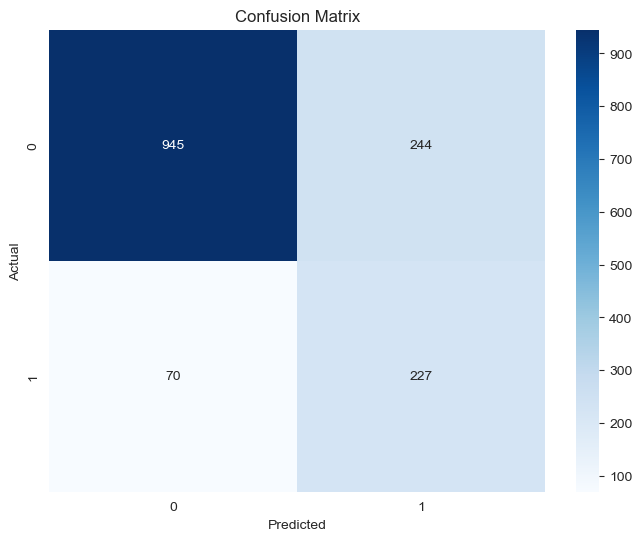

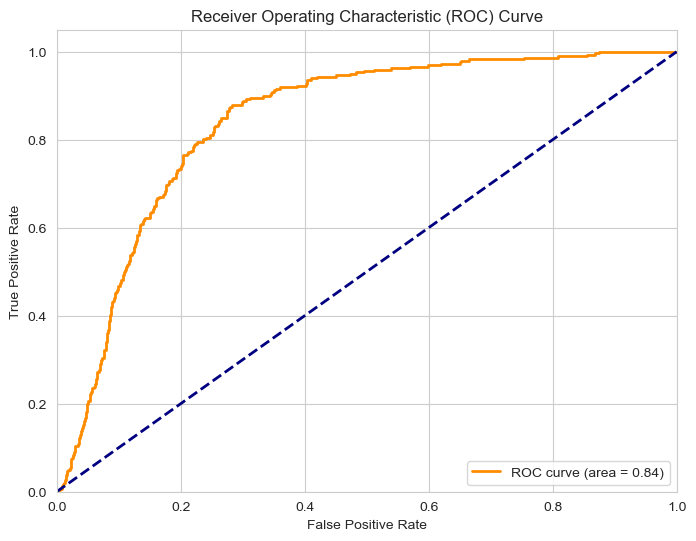

In [22]:
y_pred = best_pipeline.predict(X_test)

print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1]

print("ROC AUC: ", roc_auc_score(y_test, y_pred_proba))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")

plt.xlabel("Predicted")

plt.ylabel("Actual")

plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


Balanced accuracy:  0.8669509788096836
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      5945
           1       0.73      0.81      0.77      1485

    accuracy                           0.90      7430
   macro avg       0.84      0.87      0.85      7430
weighted avg       0.91      0.90      0.90      7430

ROC AUC:  0.9346172688477146


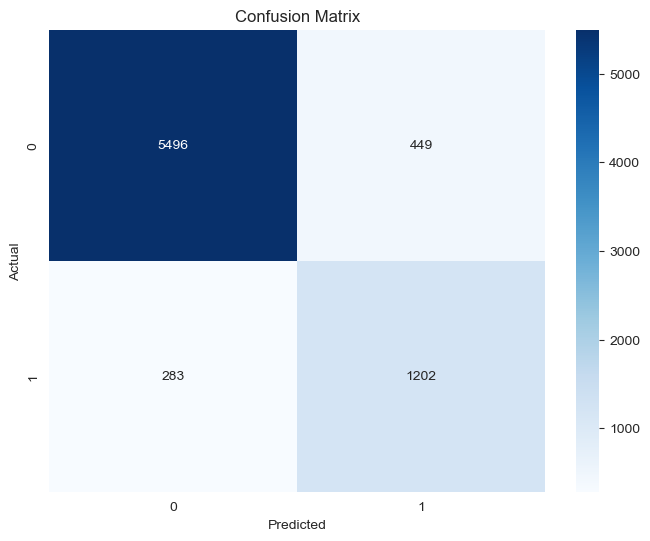

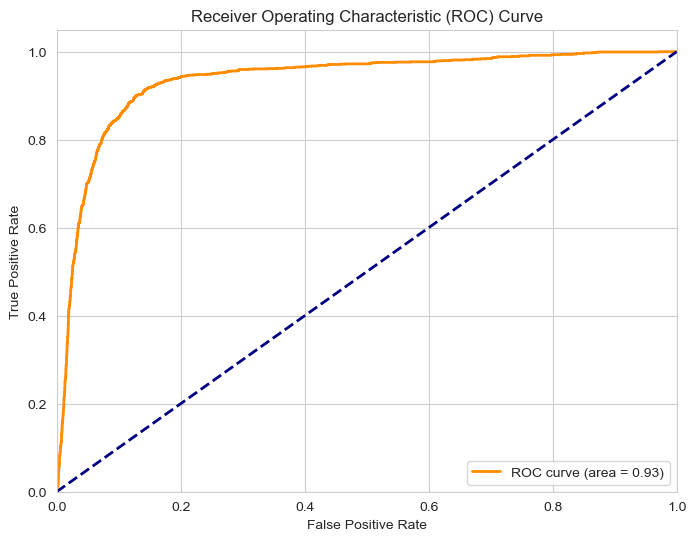

In [23]:
# Analyzing the performance over the entire dataset

y_pred = best_pipeline.predict(X)

print("Balanced accuracy: ", balanced_accuracy_score(y, y_pred))

print(classification_report(y, y_pred))

y_pred_proba = best_pipeline.predict_proba(X)[:, 1]

print("ROC AUC: ", roc_auc_score(y, y_pred_proba))

conf_matrix = confusion_matrix(y, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [24]:
df_2 = df.copy()

df_2["Pred_default (y_hat)"] = best_pipeline.predict(X)

df_2["PD"] = best_pipeline.predict_proba(X)[:, 1]

df_2

ID  Job tenure  Age  Car price  Funding amount  Down payment  \
0        1          34   55       4875            3087             0   
1        2           5   29      13000           13000             0   
2        3          14   38      17190           14190             0   
3        4          16   37      22773           23568             0   
4        5           1   61       7700            8526             0   
...    ...         ...  ...        ...             ...           ...   
7425  7426           9   38       4502            4856             0   
7426  7427           1   33      22900           17900             0   
7427  7428           3   27      25858           25972             0   
7428  7429           6   32      12300           11300             0   
7429  7430           5   47      15900           17764             0   

      Loan duration  Monthly payment  Credit event  Married  Homeowner  \
0                36         0.047895             0        1          1   
1                60         0.091667             0        0          0   
2                60         0.088235             0        0          0   
3                48         0.110084             0        1          1   
4                48         0.123404             0        1          0   
...             ...              ...           ...      ...        ...   
7425             48         0.083846             1        0          0   
7426             60         0.098000             0        0          0   
7427             24         0.181667             0        0          0   
7428             72         0.091963             0        0          1   
7429             96         0.135000             0        1          0   

      Default (y)  Pred_default (y_hat)            PD  Group  
0               0                     0  1.049082e-09      1  
1               1                     1  7.000407e-01      0  
2               0                     0  5.284206e-02      0  
3               0                     0  6.506727e-07      1  
4               1                     0  1.365055e-01      0  
...           ...                   ...           ...    ...  
7425            1                     1  9.890595e-01      0  
7426            0                     0  4.113501e-03      0  
7427            0                     0  1.200342e-02      0  
7428            0                     0  2.188012e-01      0  
7429            0                     0  2.224626e-01      0  

[7430 rows x 15 columns]

In [25]:
# df_2.to_csv("../Data/black_box_3_data.csv", index=False)


# Exercise 04:
## Global interpretability: Implement one or two surrogate model(s) to interpret your own model

In [26]:
# Loading the data produced by our own black-box model
df = pd.read_csv("../Data/black_box_3_data.csv")

# Rename column
df.rename(
    columns={"Monthly payment to income ratio": "Monthly payment to funding ratio"},
    inplace=True,
)


### Surrogate Model for our Own Black-Box Model: Logistic Regression

In [27]:
# Define feature set (X) and target (y)
X = df.drop(
    columns=["Pred_default (y_hat)", "Default (y)", "PD", "Group"]
)  # Dropping non-feature columns
y = df["Pred_default (y_hat)"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the logistic regression model
log_reg = LogisticRegression(max_iter=5000)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

# Performance metrics
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)


# Print the metrics
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nClassification Report:\n", classification_rep)

# Inspect feature importance (coefficients in logistic regression)
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": log_reg.coef_[0]}
).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Logistic Regression Coefficients):\n", feature_importance)


Balanced Accuracy: 0.66
Precision: 0.64
Recall: 0.37
F1 Score: 0.47

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      1164
           1       0.64      0.37      0.47       322

    accuracy                           0.82      1486
   macro avg       0.74      0.66      0.68      1486
weighted avg       0.80      0.82      0.80      1486


Feature Importance (Logistic Regression Coefficients):
                              Feature  Coefficient
7                       Credit event     1.514116
4                       Down payment     0.247846
13      Job tenure * Monthly payment     0.065087
14             Age * Monthly payment     0.031280
5                      Loan duration     0.009220
12                  Job tenure * Age     0.003655
3                     Funding amount     0.000328
10  Monthly payment to funding ratio    -0.000048
2                          Car price    -0.000277
1                      

### Surrogate Model for Own Blackbox: Linear Regression

In [28]:
# Define feature set (X) and target (y, in this case PD)
X = df.drop(
    columns=["PD", "Default (y)", "Pred_default (y_hat)", "Group"]
)  # Dropping non-feature columns
y = df["PD"]

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize the Linear Regression model
lin_reg = LinearRegression()

# Train the model
lin_reg.fit(X_train, y_train)

# Predict on the test set
y_pred_prob = lin_reg.predict(X_test)

y_test_pred = np.where(y_test > 0.5, 1, 0)
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Performance metrics for regression
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred_prob)

balanced_accuracy = balanced_accuracy_score(y_test_pred, y_pred)

# Print the metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"R^2 Score: {r2:.4f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Coefficient": lin_reg.coef_}
).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Linear Regression Coefficients):\n", feature_importance)


Mean Squared Error: 0.1478
R^2 Score: 0.2551
Balanced Accuracy: 0.60

Feature Importance (Linear Regression Coefficients):
                              Feature  Coefficient
7                       Credit event     0.245728
11           Loan to car price ratio     0.211010
4                       Down payment     0.116662
14             Age * Monthly payment     0.014197
5                      Loan duration     0.001365
12                  Job tenure * Age     0.000440
3                     Funding amount     0.000020
2                          Car price    -0.000013
1                                Age    -0.004418
13      Job tenure * Monthly payment    -0.023316
0                         Job tenure    -0.026307
8                            Married    -0.054852
9                          Homeowner    -0.108360
6                    Monthly payment    -0.117527
10  Monthly payment to funding ratio -1149.261640


### Surrogate Model for Own Blackbox: L1 Logistic Regression

In [29]:
X = df.drop(columns=["PD", "Default (y)", "Pred_default (y_hat)", "Group"])
y = df["Pred_default (y_hat)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(
    penalty="l1", solver="saga", C=1.0, max_iter=5000
)  # 'saga' solver supports L1 penalty
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy}")

Balanced Accuracy: 0.6660129986553115


In [30]:
feature_names = (
    X.columns
    if isinstance(X, pd.DataFrame)
    else [f"feature_{i}" for i in range(X.shape[1])]
)

# Extracting coefficients
coefficients = (
    model.coef_.flatten()
)  # Flatten in case of binary classification (1 class)

# Creating a DataFrame of feature names and their corresponding coefficients
feature_importance = pd.DataFrame(
    {"Feature": feature_names, "Coefficient": coefficients}
)

# Sorting by the absolute value of the coefficients (importance)
feature_importance["Importance"] = np.abs(feature_importance["Coefficient"])
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)


# Display the top features
print("\nFeature Importance (L1 Logistic Regression Coefficients):\n")
print(feature_importance)



Feature Importance (L1 Logistic Regression Coefficients):

                             Feature  Coefficient  Importance
0                         Job tenure    -2.316192    2.316192
12                  Job tenure * Age     1.999719    1.999719
3                     Funding amount     1.246317    1.246317
2                          Car price    -1.035505    1.035505
9                          Homeowner    -0.417573    0.417573
1                                Age    -0.343203    0.343203
11           Loan to car price ratio     0.324314    0.324314
14             Age * Monthly payment     0.243210    0.243210
7                       Credit event     0.213057    0.213057
8                            Married    -0.212623    0.212623
5                      Loan duration     0.149788    0.149788
10  Monthly payment to funding ratio    -0.120460    0.120460
4                       Down payment     0.116800    0.116800
6                    Monthly payment    -0.033965    0.033965
13      Jo

### Surrogate Model for Own Blackbox: Decision Tree

In [31]:
df = pd.read_csv("../Data/black_box_3_data.csv")
# Separate features and target
X = df.drop(columns=["Pred_default (y_hat)"])
X = X.drop(columns=["PD", "Group", "Default (y)"])
y = df["PD"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Train a decision tree regressor as the surrogate model
surrogate_model = DecisionTreeRegressor(max_depth=4)
surrogate_model.fit(X_train, y_train)

# Make predictions with the surrogate model
y_pred_surrogate = surrogate_model.predict(X_test)

# Define a threshold to convert regression output into binary classification (assuming PD is a binary outcome)
# For example, let's assume a threshold of 0.5
y_pred_classes = (y_pred_surrogate >= 0.5).astype(int)  # Convert predictions to 0 and 1

# Convert the actual target values to binary classes as well (assuming a threshold)
y_test_classes = (y_test >= 0.5).astype(int)

# Calculate accuracy (for binary classification)
balanced_accuracy = balanced_accuracy_score(y_test_classes, y_pred_classes)

# Calculate R-squared (for regression)
r2 = r2_score(y_test, y_pred_surrogate)

# Print the results
print(f"R-squared for the surrogate model: {r2}")
print(f"Balanced Accuracy for the surrogate model: {balanced_accuracy}")


R-squared for the surrogate model: 0.23922110204194025
Balanced Accuracy for the surrogate model: 0.6234659561621523


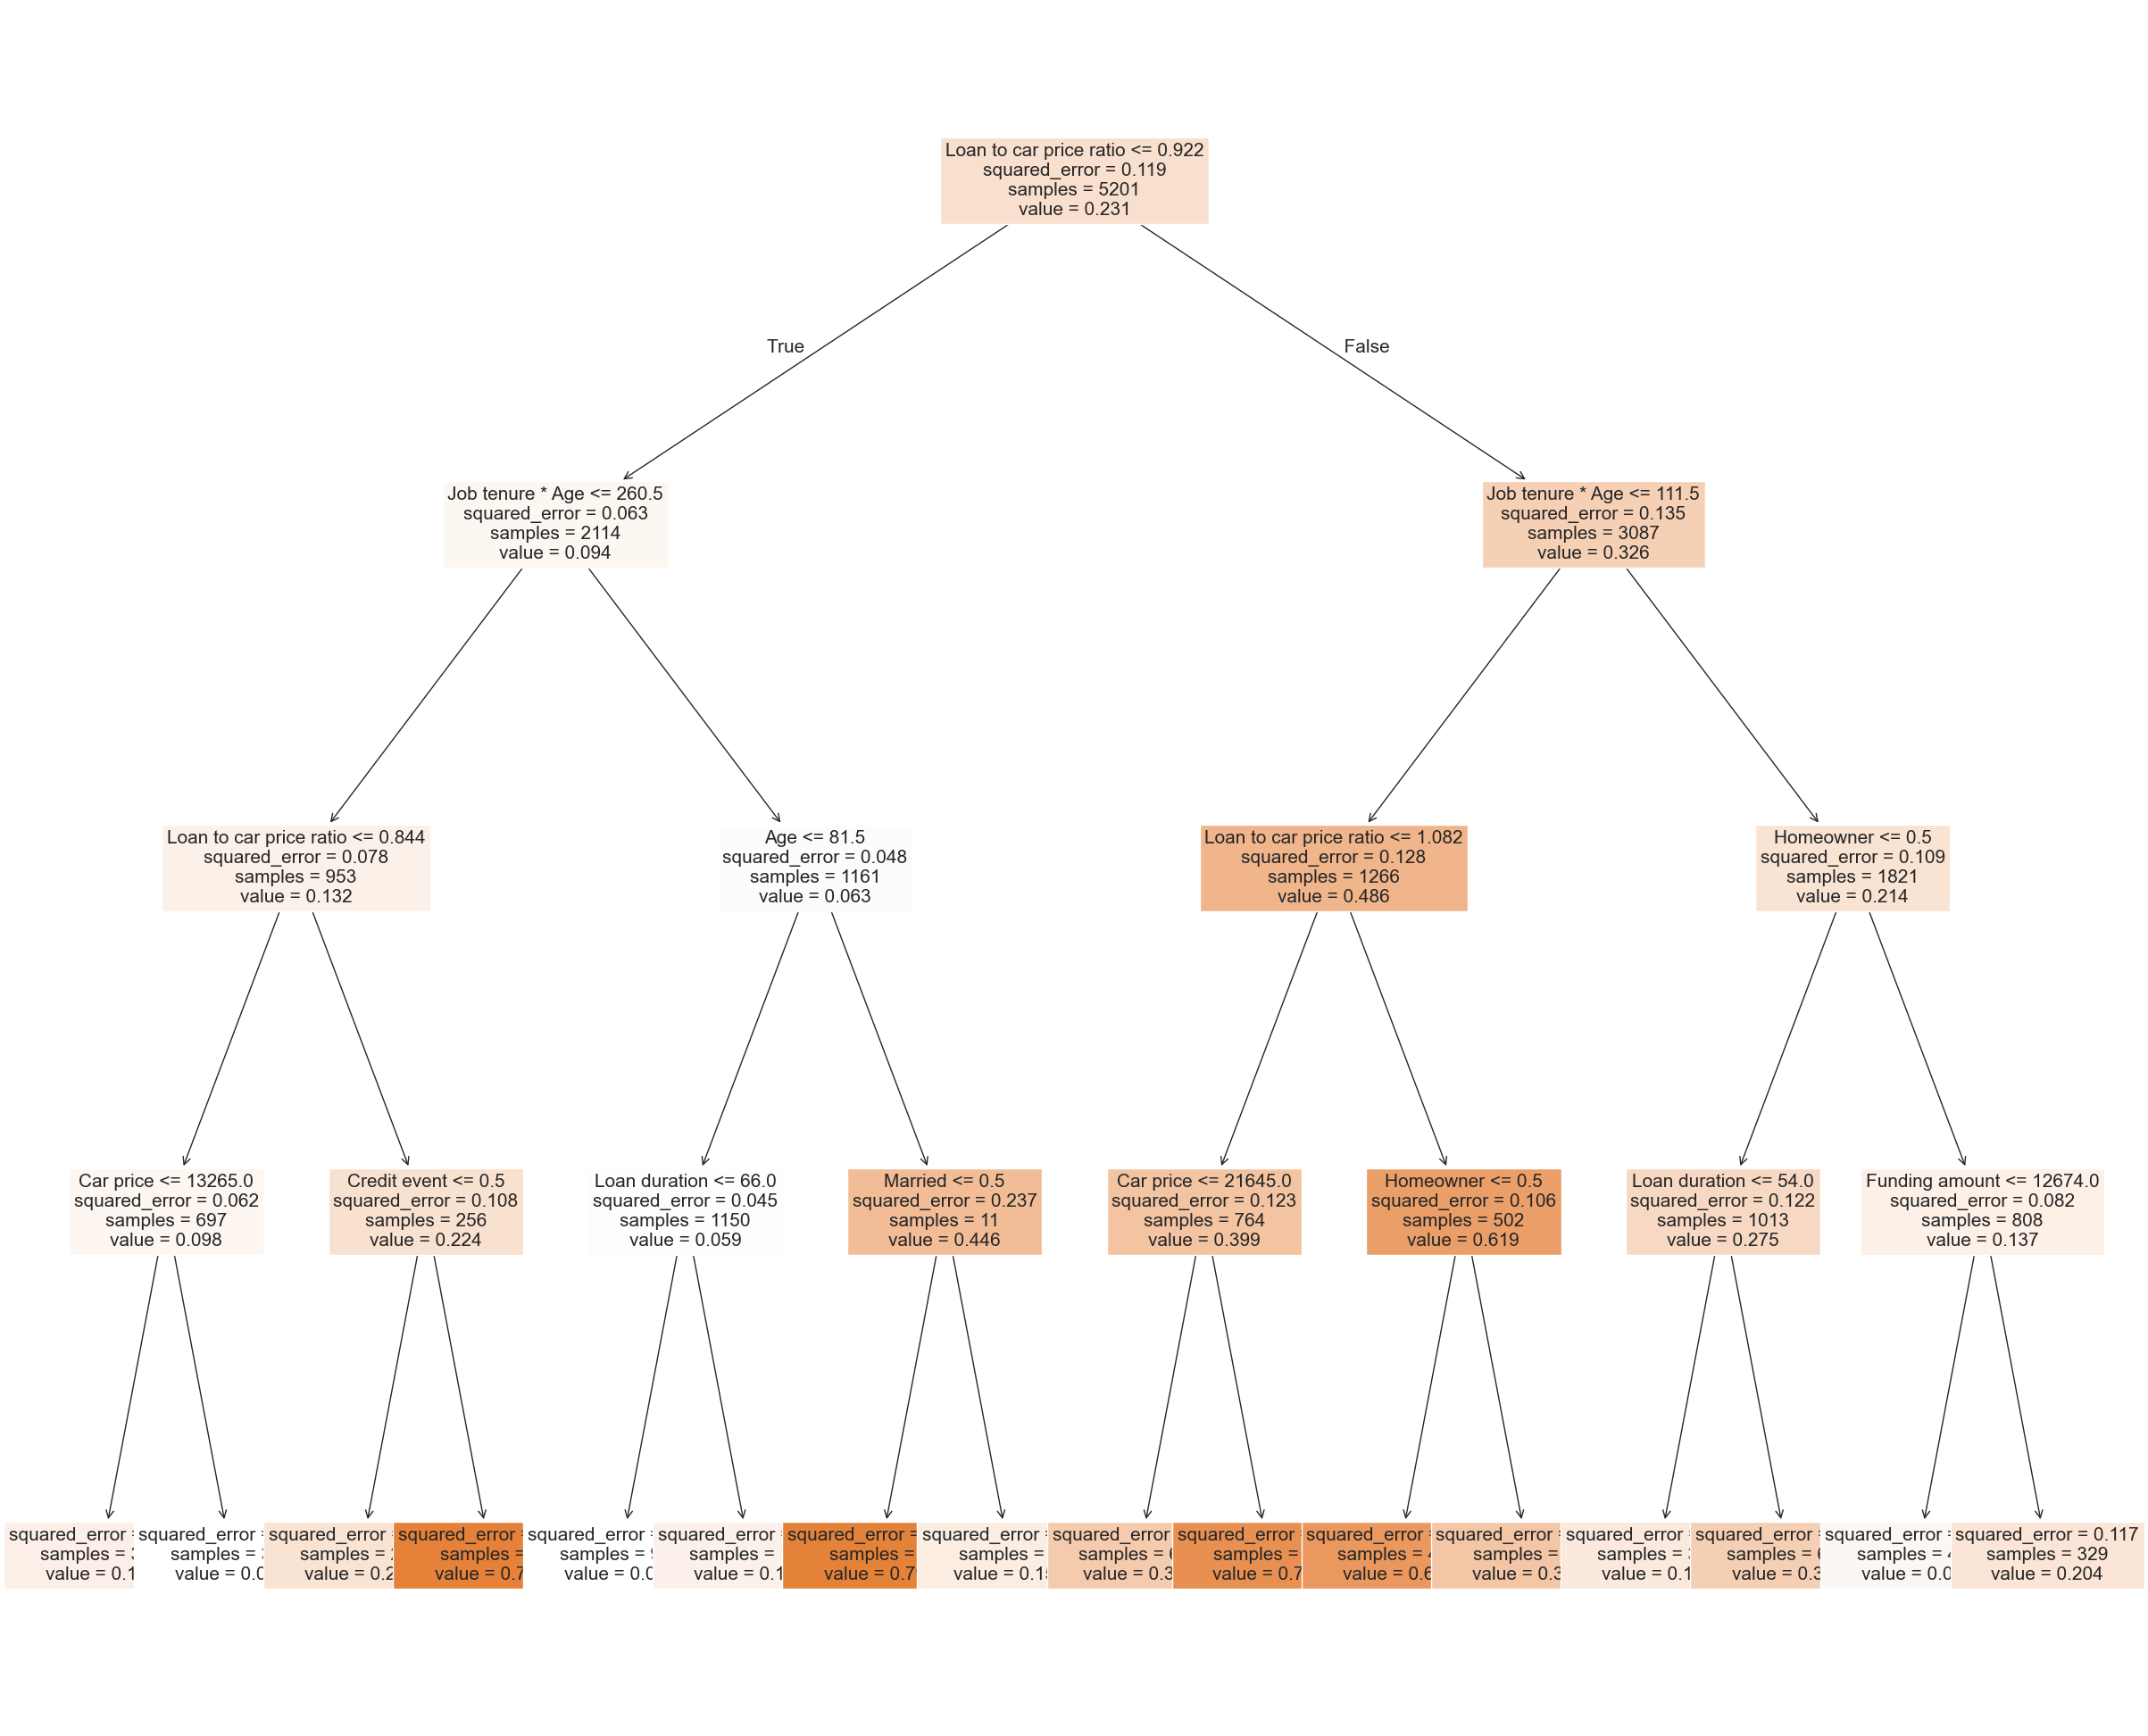

In [32]:
# Plot the decision tree with larger font and bigger nodes
plt.figure(figsize=(30, 25))  # Control the figure size
plot_tree(
    surrogate_model,
    feature_names=X.columns,
    filled=True,
    fontsize=15,  # Increase the font size in the boxes
    proportion=False,  # Ensure nodes are not scaled based on proportion
)
plt.show()


# Exercise 05
## Global interpretability: Implement the PDP method to interpret your own model.

In [33]:
df = pd.read_csv("../Data/black_box_3_data.csv")

X = df.drop(columns=["Pred_default (y_hat)", "Default (y)", "PD", "Group"])
y = df["Pred_default (y_hat)"]

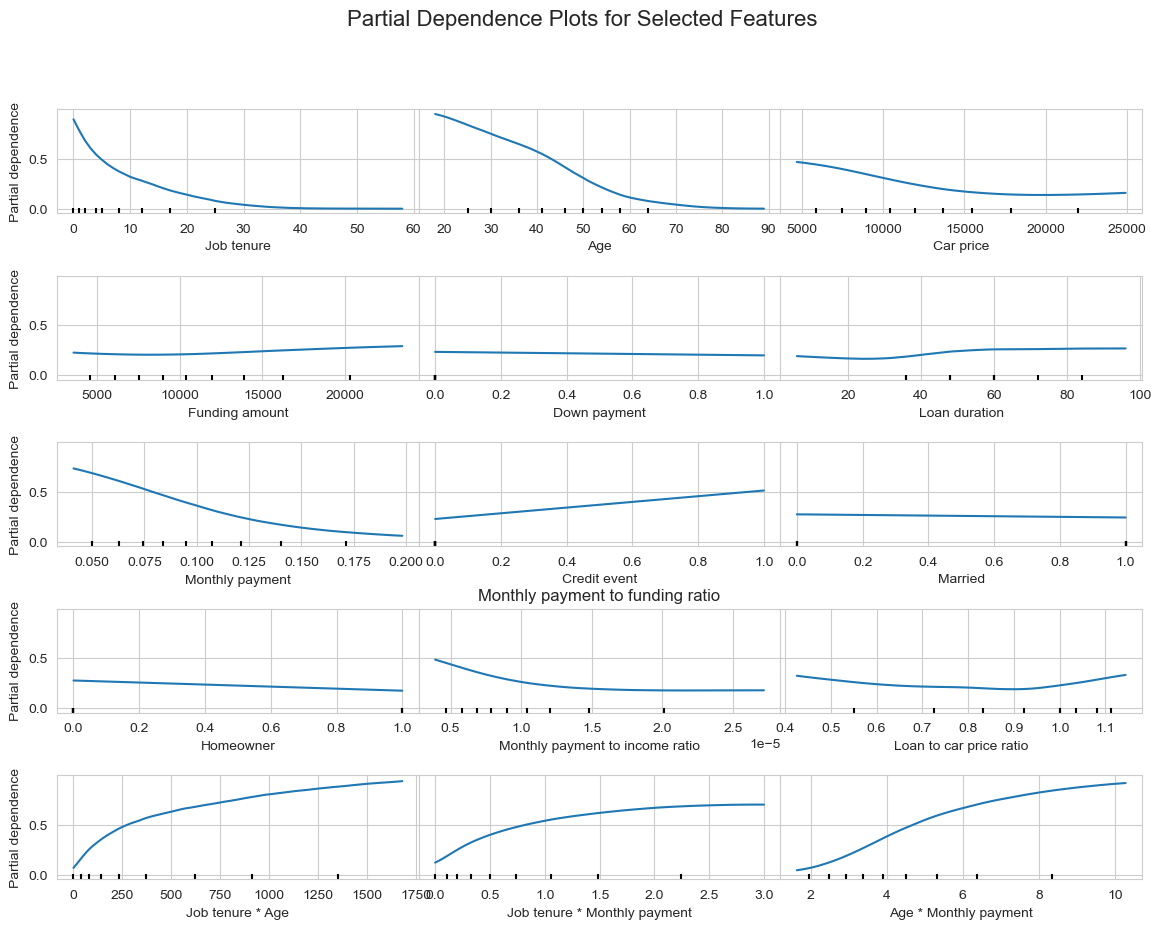

In [34]:
features = X.columns

# Generate the partial dependence plot using the original feature names
fig, ax = plt.subplots(figsize=(14, 10))
display = PartialDependenceDisplay.from_estimator(best_pipeline, X, features, ax=ax)

# Adjust the display names directly on the plot
for ax, feature in zip(display.axes_.ravel(), features):
    if feature == "Monthly payment to income ratio":
        ax.set_title("Monthly payment to funding ratio")

plt.subplots_adjust(hspace=0.6, wspace=0.0)
fig.suptitle("Partial Dependence Plots for Selected Features", fontsize=16)
plt.show()

### Partial Dependence Plot Insights on Loan Default Probability

Each plot shows how the feature affects the probability of loan default, controlling for the average effect of other features in the model.

1. **Job Tenure**: As job tenure increases, the likelihood of default significantly decreases. This suggests that borrowers with more stable employment (longer job tenure) are less likely to default.

2. **Age**: A similar trend is observed with age. Younger individuals (around 20–40) have a higher probability of default, while older individuals (above 60) have a much lower risk of default. Older borrowers may be more financially stable.

3. **Car Price**: As the car price increases, the likelihood of default decreases slightly. Borrowers purchasing more expensive cars may have higher incomes or better credit profiles, reducing their risk of default.

4. **Funding Amount**: There is very little variation in the partial dependence of the funding amount on the likelihood of default. This suggests that the total amount funded doesn’t significantly affect the probability of default, at least within the range considered.

5. **Down Payment**: Higher down payments are slightly associated with a lower likelihood of default, though the relationship is not very strong. Larger down payments indicate greater upfront financial commitment from borrowers, which may reduce default risk.

6. **Loan Duration**: The plot shows a relatively flat line, implying that loan duration does not have a strong influence on the likelihood of default, at least within the range of values considered.

7. **Monthly Payment**: Higher monthly payments are associated with a slightly lower likelihood of default. This could indicate that borrowers who can afford higher monthly payments are less likely to default, potentially due to higher incomes or better financial management.

8. **Credit Event**: The likelihood of default decreases as the credit event variable (likely representing a better credit history or fewer negative events) improves. Borrowers with better credit histories are less likely to default.

9. **Married**: There is no strong trend between being married and the likelihood of default. The partial dependence plot is quite flat, indicating marriage status may not have a significant influence on default risk.

10. **Homeowner**: The partial dependence plot shows that homeowners are less likely to default on car loans. Homeownership can be seen as a sign of financial stability.

11. **Monthly Payment to Funding Ratio**: As the monthly payment to funding ratio increases, the likelihood of default slightly increases. Borrowers dedicating a larger proportion of their funding to car payments may be more financially stressed and thus more likely to default.

12. **Loan to Car Price Ratio**: A higher loan-to-car price ratio is associated with a higher likelihood of default. Borrowers who finance a larger portion of the car price (i.e., lower down payments or higher loans) tend to be at greater risk of default.

### Interaction Terms

13. **Job Tenure * Age**: The likelihood of default decreases for individuals with both longer job tenure and increasing age. This suggests that stability in both job and life stages reduces the risk of default.

14. **Job Tenure * Monthly Payment**: As both job tenure and monthly payment increase, the likelihood of default decreases. This reinforces the idea that job stability and higher financial capacity reduce default risk.

15. **Age * Monthly Payment**: For younger borrowers, higher monthly payments are associated with a slight increase in the likelihood of default, but for older borrowers, higher payments are associated with a decreased likelihood of default. This suggests that older borrowers with higher payments are more financially secure.

### Overall Insights

- Financial stability (as indicated by longer job tenure, homeownership, and lower monthly payment to funding ratio) and creditworthiness (as indicated by credit events and loan-to-car price ratio) are the strongest predictors of reduced default risk.
- Demographic factors like age and marital status have less influence on default likelihood, but older borrowers generally exhibit lower risk.
- Borrowers with larger down payments or purchasing more expensive cars tend to have a lower default risk, indicating that these factors may reflect higher financial commitment and stability.


# Exercise 06:
## Local interpretability: Implement the ICE method to interpret your own model.

In [35]:
df = pd.read_csv("../Data/black_box_3_data.csv")
X = df.drop(columns=["Default (y)", "Pred_default (y_hat)", "PD", "Group"])
y = df["Default (y)"]

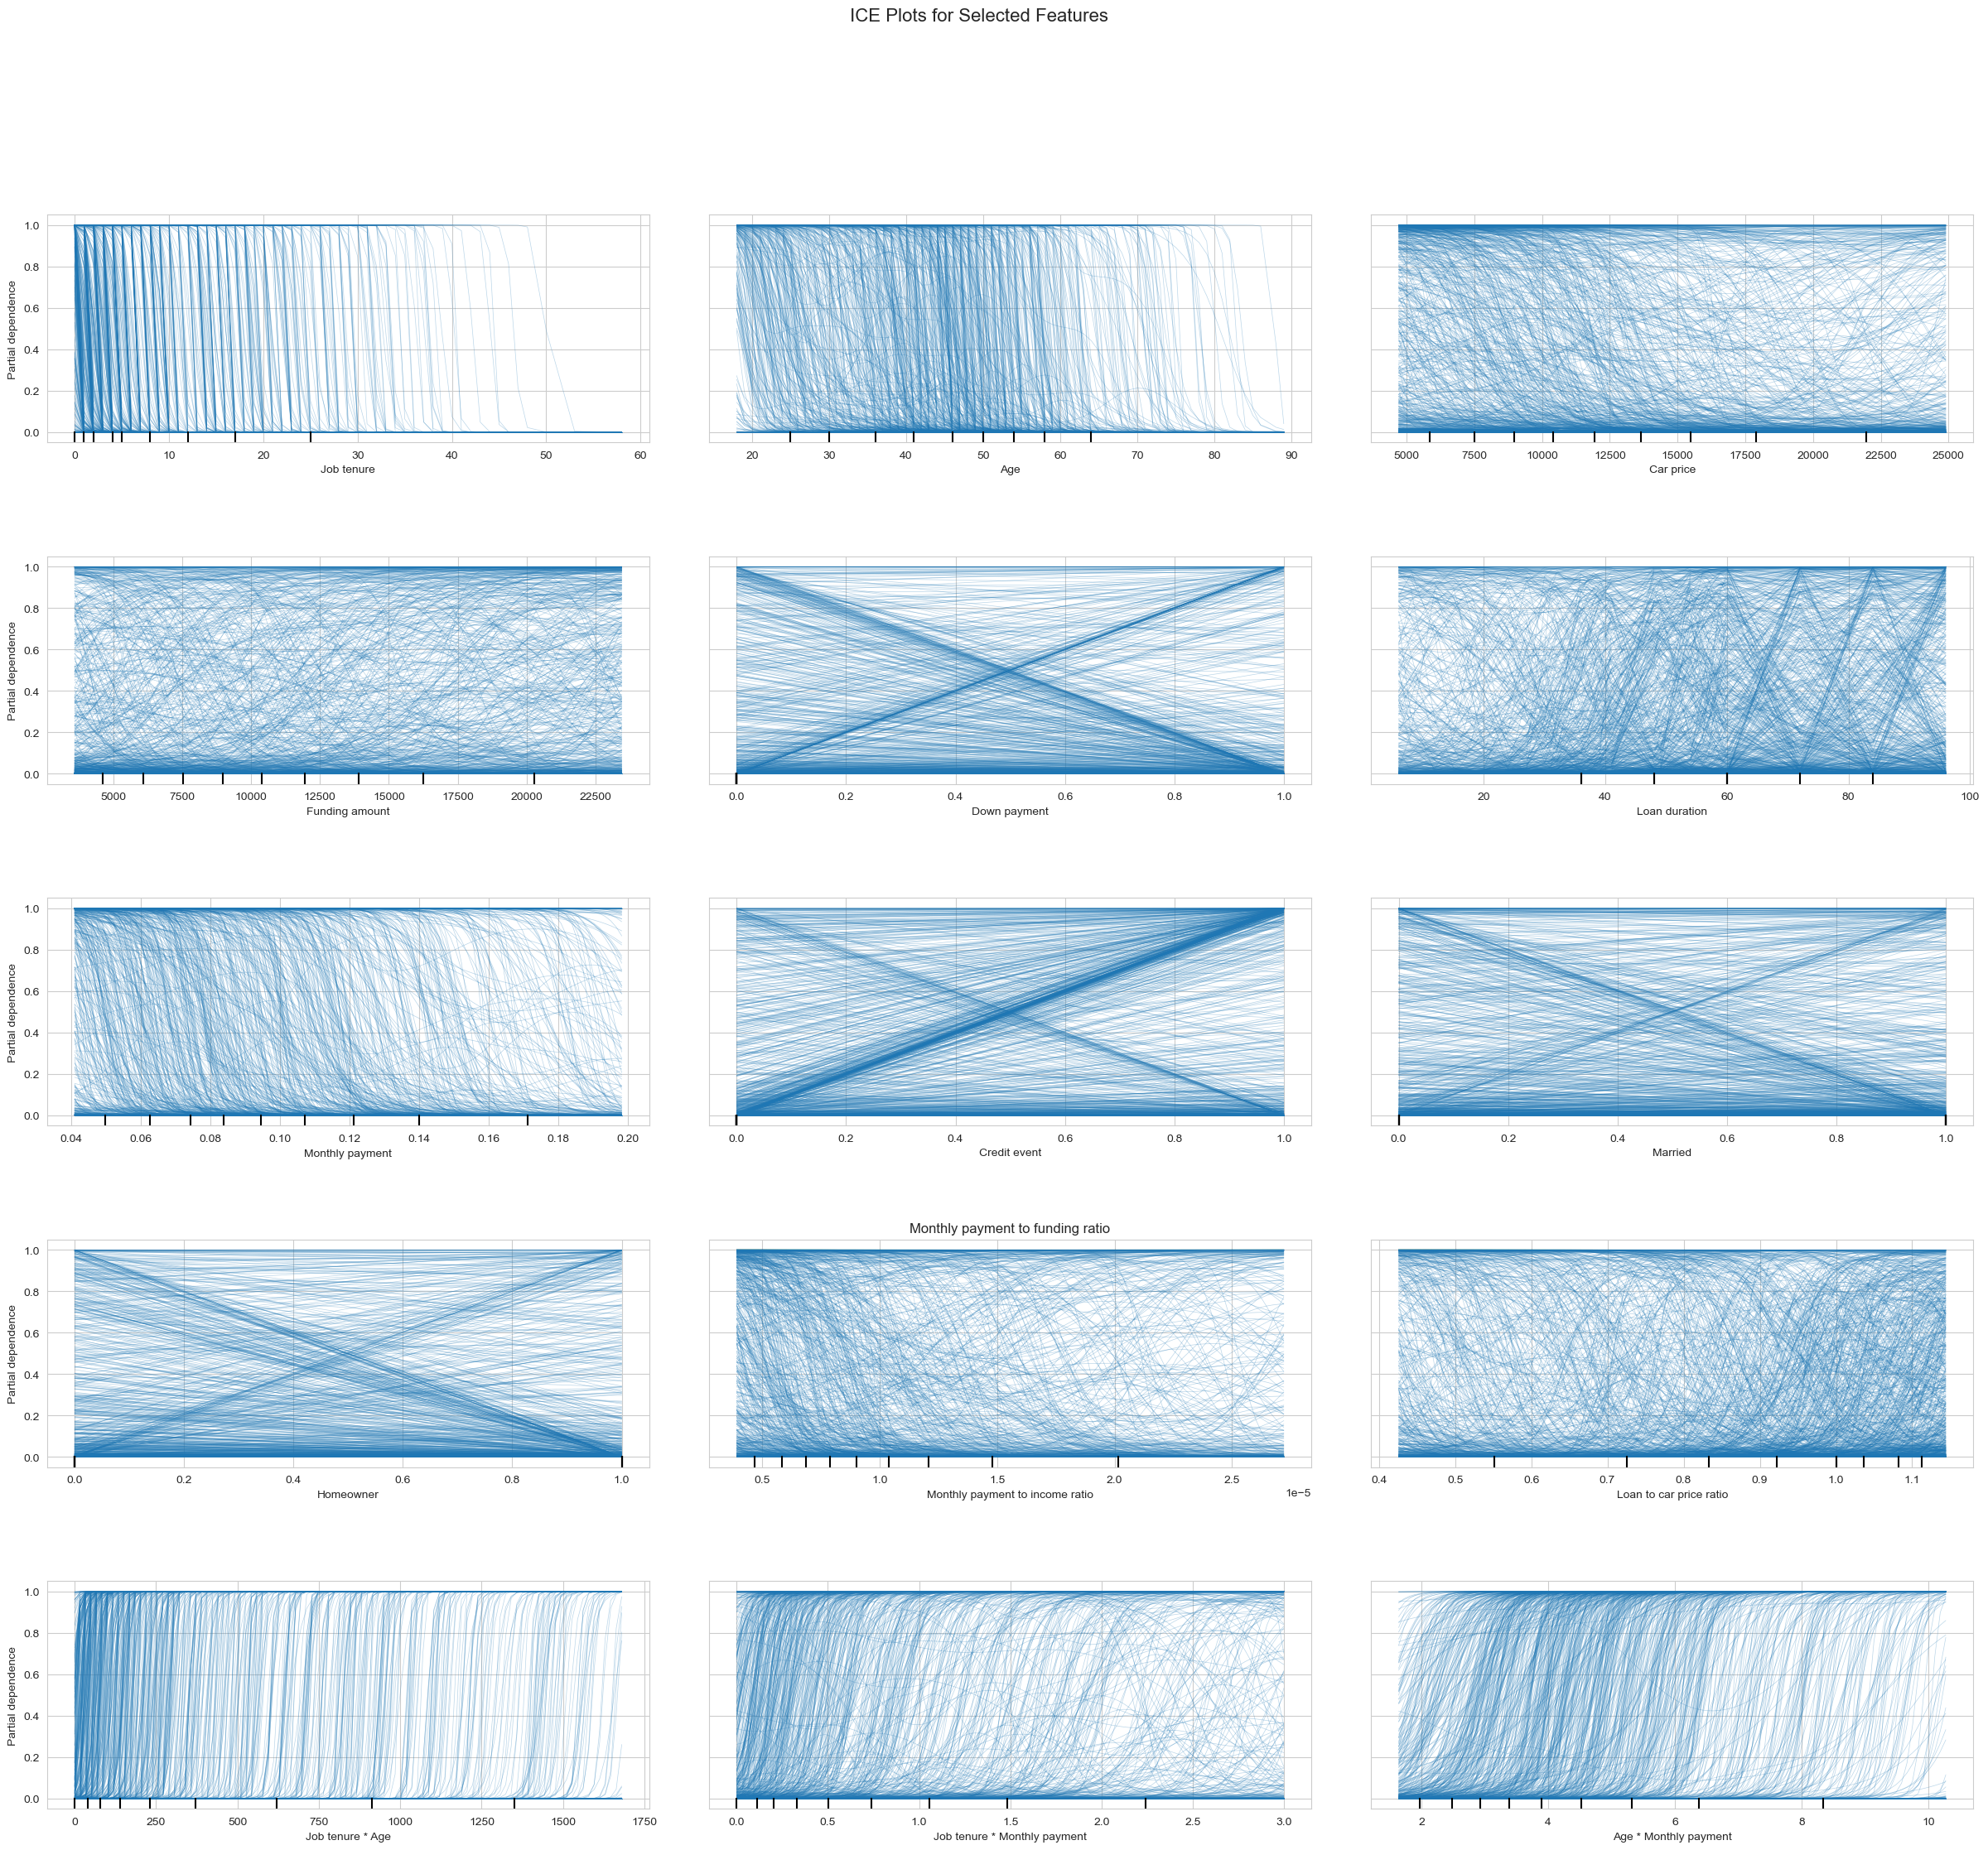

In [36]:
# Keep original X and feature names
features = X.columns

# Generate the ICE plots using the original feature names
fig, ax = plt.subplots(figsize=(30, 25))

display = PartialDependenceDisplay.from_estimator(
    best_pipeline,
    X,  # The feature matrix (input data)
    features=range(len(features)),  # Plot ICE for all features
    kind="individual",  # ICE: Individual Conditional Expectation
    ax=ax,
)

# Adjust the display names directly on the plot
for ax, feature in zip(display.axes_.ravel(), features):
    if feature == "Monthly payment to income ratio":
        ax.set_title("Monthly payment to funding ratio")

plt.subplots_adjust(hspace=0.5, wspace=0.1)
fig.suptitle("ICE Plots for Selected Features", fontsize=16)
plt.show()


# Individual Conditional Expectation (ICE) Plot Insights on Loan Default Probability

Each plot shows how the feature affects the probability of loan default for individual borrowers, controlling for the average effect of other features in the model.

1. **Job Tenure**: All individual lines show a sharp decline in default probability as job tenure increases. Most borrowers experience a steep decrease in default risk after the first 10 years of tenure.

2. **Age**: As age increases, the likelihood of default decreases for most borrowers. Younger individuals (especially under 40) have much higher default probabilities, while older borrowers show a sharp decline in risk, with most lines flattening after the age of 50.

3. **Car Price**: The effect of car price on default is more nuanced. Some borrowers see a decreasing likelihood of default with more expensive cars, while for others, the change is more gradual. The model is less sensitive to car price, though higher prices generally lead to lower default probabilities.

4. **Funding Amount**: The effect of funding amount on default likelihood is complex, with no clear overall trend. The lines frequently cross each other, suggesting that different borrowers are affected in different ways by the amount of funding.

5. **Down Payment**: The relationship between down payment and default likelihood varies, where some lines increase and others decrease. For some borrowers, larger down payments reduce default risk, while for others, it has less impact.

6. **Loan Duration**: Loan duration shows a mixed pattern, with individual responses varying greatly. For some, longer loan durations increase the likelihood of default, while for others, duration has little effect.

7. **Monthly Payment**: Higher monthly payments generally reduce the probability of default for many borrowers, though the relationship is not strictly linear across all cases.

8. **Credit Event**: Borrowers with fewer credit events show a decreasing likelihood of default, reinforcing that a better credit history correlates with lower default risk.

9. **Married**: The marriage feature doesn’t show a strong pattern, indicating that marriage status has minimal impact on the default prediction.

10. **Homeowner**: Homeownership correlates with a lower likelihood of default for most borrowers, as indicated by the downward trend in the majority of lines.

11. **Monthly Payment to Funding Ratio**: There is a generally increasing risk of default as the monthly payment-to-funding ratio increases, though the magnitude varies across borrowers.

12. **Loan to Car Price Ratio**: A higher loan-to-car price ratio leads to a greater likelihood of default for most borrowers, though there is still considerable variability among different profiles.

### Interaction Terms

13. **Job Tenure * Age**: Older borrowers with longer job tenures show a lower probability of default. The lines mostly trend downwards, indicating that both age and job tenure significantly reduce default risk when considered together.

14. **Job Tenure * Monthly Payment**: As job tenure increases, higher monthly payments lead to a lower likelihood of default for many borrowers, especially those with stable employment and greater payment capacity.

15. **Age * Monthly Payment**: Older borrowers with higher monthly payments tend to have a lower likelihood of default, while younger borrowers show more variation, indicating that older individuals are better able to manage higher payments.

### Overall Interpretation

- Features like job tenure, age, monthly payment, and homeownership consistently reduce the likelihood of default for most borrowers.
- Features such as funding amount, down payment, and loan duration show more individual variation, meaning their impact on default risk depends heavily on the borrower's specific situation.
- The interaction terms reveal more complex relationships between features (e.g., job tenure and age, or monthly payment and job tenure), influencing default in distinct ways for different borrowers.


# Exercise 07
## Local interpretability: Implement the SHAP method to interpret your own model

In [37]:
df = pd.read_csv("../Data/black_box_3_data.csv")

X = df.drop(columns=["Default (y)", "Pred_default (y_hat)", "PD", "Group"])
y = df["Default (y)"]

# # Load the model
# model = joblib.load("../Models/MLP_model_only.pkl")

# # Scale X using the scaler from the pipeline
# scaler = joblib.load("../Models/MLP_scaler_only.pkl")
X_scaled = best_scaler.transform(X)
X.rename(
    columns={"Monthly payment to income ratio": "Monthly payment to funding ratio"},
    inplace=True,
)
# # Create the explainer
# explainer = shap.Explainer(model.predict_proba, X_scaled)

# # Calculate SHAP values
# shap_values = explainer(X_scaled)


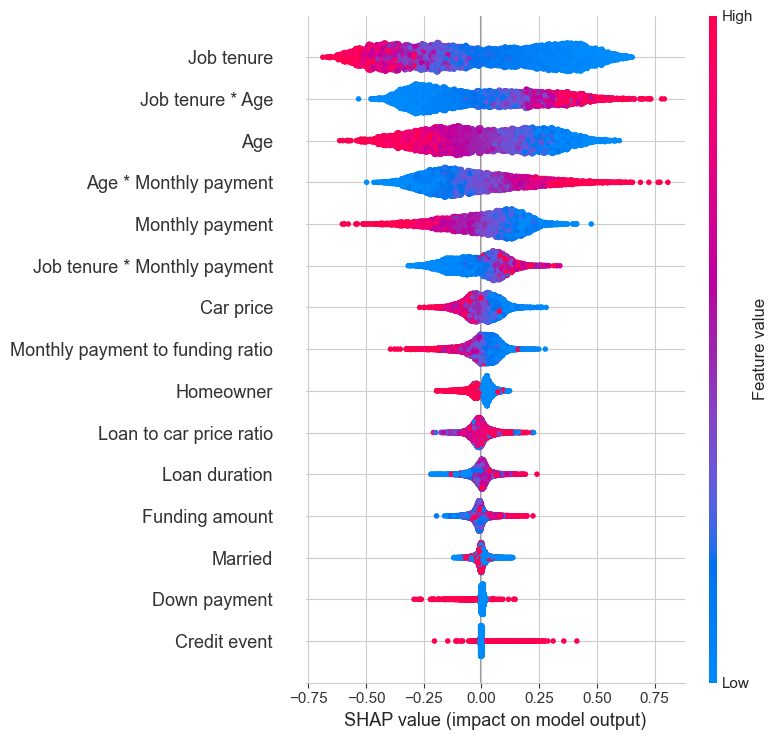

In [38]:
# Loading previously obtained SHAP values to save time
shap_values_df = pd.read_csv("../Data/shap_values.csv")
shap_values_class_1 = shap_values_df.values
shap.summary_plot(shap_values_class_1, X_scaled, feature_names=X.columns)

# SHAP Summary Plot Interpretation

In the SHAP summary plot above, each dot represents the impact of a feature on the prediction for an individual sample. The plot displays how the feature values affect the model's output, which is a binary classification task (predicting car loan default, where 0 is no default and 1 is default).
## 1. X-axis (SHAP Value)
The SHAP value on the x-axis shows how much each feature contributes to increasing or decreasing the probability of car loan default.  
- SHAP values to the left (negative) push the model's prediction towards no default (0), and SHAP values to the right (positive) push the model’s prediction towards default (1).

## 2. Y-axis (Features)
Features are ranked by their overall importance, with the most important features at the top. In this case:
- **Job tenure** is the most important feature affecting the prediction of car loan default.
- **Credit event** is the least important feature in this context.

## 3. Color of Dots (Feature Value)
The color of each dot represents the feature value:
- **Red dots** represent higher values of the feature.
- **Blue dots** represent lower values of the feature.

## 4. Interpretation of Key Features

### Job Tenure:
- **Higher job tenure (red)** reduces the likelihood of default (negative SHAP values).
- **Lower job tenure (blue)** increases the likelihood of default (positive SHAP values).
- This suggests that people with longer job tenure are less likely to default, which aligns with the idea that job stability can indicate financial stability.

### Job Tenure * Age (Interaction Term):
- **Older individuals with longer job tenure (red)** tend to have a lower chance of default.
- **Younger individuals with shorter job tenure (blue)** are more likely to default.

### Age:
- **Younger borrowers (blue)** are associated with a higher likelihood of default (positive SHAP values).
- **Older borrowers (red)** tend to have a lower chance of default.

### Age * Monthly Payment (Interaction Term):
- **High monthly payments for younger individuals (blue)** increase the likelihood of default.
- **Low monthly payments for older individuals (red)** decrease the likelihood of default.

### Monthly Payment:
- **Higher monthly payments (red)** increase the likelihood of default.
- **Lower payments (blue)** reduce the likelihood of default.

### Job Tenure * Monthly Payment (Interaction Term):
- **Low job tenure combined with high monthly payments (blue)** increases the likelihood of default.

### Car Price:
- **Higher car prices (red)** slightly increase the chance of default.
- **Lower car prices (blue)** are associated with a reduced likelihood of default.

### Monthly Payment to Funding Ratio:
- Borrowers with a **high monthly payment to funding ratio (red)** are more likely to default, while those with a **low ratio (blue)** are less likely to default.
- This makes sense because higher ratios mean the monthly payments take up a larger portion of their funding.

### Homeowner:
- **Non-homeowners (blue)** are slightly more likely to default.

### Loan to Car Price Ratio:
- Borrowers with a **higher loan-to-car price ratio (red)** are more likely to default.
- This suggests that borrowers who finance a larger portion of the car’s value are at a greater risk of default.

### Loan Duration:
- **Longer loan durations (red)** slightly increase the likelihood of default, while shorter loans (blue) reduce it.

### Funding Amount:
- Borrowers with **higher funding amounts (red)** have a small increase in default likelihood.

### Married:
- **Married borrowers (blue)** are less likely to default, while those who are **not married (red)** have a higher likelihood of default.

### Down Payment:
- Borrowers with **higher down payments (red)** have a lower likelihood of default.
- **Lower down payments (blue)** increase the risk of default, which makes sense because a higher down payment reduces the overall loan amount.

### Credit Event:
- **A credit event (red)** is a significant risk factor, strongly increasing the likelihood of default.

## Conclusion
The SHAP plot provides clear insights into the most important features driving the predictions in the car loan default model. 
- **Job tenure**, **age**, **monthly payment**, and **monthly payment to funding ratio** are key factors, with lower job tenure, younger age, higher monthly payments, and a higher payment-to-funding ratio associated with a higher risk of default.
- Conversely, factors like being **married**, having **long job tenure**, and making **higher down payments** reduce the likelihood of default.


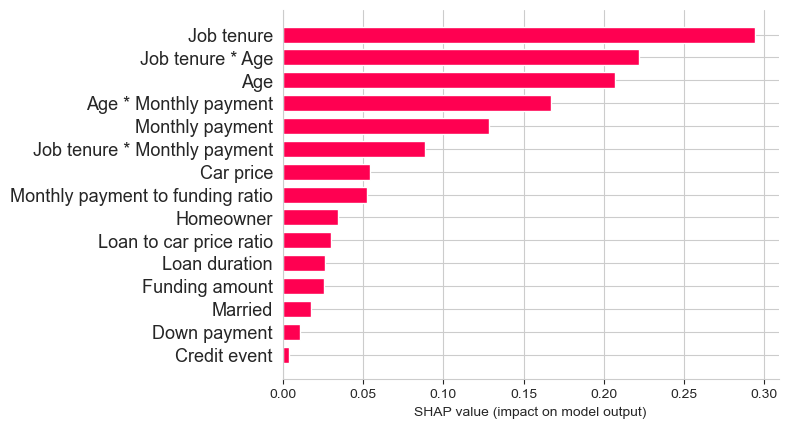

In [39]:
# Aggregate SHAP values by taking the mean of the absolute values for each feature
mean_abs_shap_values = shap_values_df.abs().mean()

# Generate the SHAP bar plot
# Set max_display to a large number to show all features
shap.bar_plot(
    mean_abs_shap_values,
    feature_names=X.columns,
    max_display=len(shap_values_df.columns),
)


### Comparing SHAP and ICE for Each Feature

1. **Job Tenure**  
   SHAP: Job tenure is the most important feature, and longer job tenure decreases the probability of default, as indicated by negative SHAP values.  
   ICE: The ICE plot confirms this trend, showing that most borrowers exhibit a sharp decrease in default probability as job tenure increases. The consistent downward trend in ICE aligns with SHAP, where higher job tenure leads to lower default risk.

2. **Job Tenure * Age (Interaction Term)**  
   SHAP: This interaction is highly influential, showing varying effects depending on the combination of job tenure and age.  
   ICE: The ICE plot shows that longer job tenure combined with increasing age reduces default risk, reflecting the combined stability from both age and job experience.

3. **Age**  
   SHAP: Age is an important factor, with older borrowers generally having lower default risk, indicated by negative SHAP values for higher age.  
   ICE: The ICE plot shows that as age increases, the probability of default decreases sharply, consistent with SHAP values.

4. **Age * Monthly Payment (Interaction Term)**  
   SHAP: This interaction shows varying effects based on the combination of age and monthly payment.  
   ICE: The ICE plot reveals that older borrowers with higher monthly payments have lower default risk, while younger borrowers experience higher default risk with increasing payments. This reflects the complex interaction between financial capacity and life stage.

5. **Monthly Payment**  
   SHAP: Monthly payment is influential, with higher payments generally associated with lower default risk.  
   ICE: The ICE plot confirms this, showing reduced default risk with higher payments, though variability across borrowers exists.

6. **Job Tenure * Monthly Payment (Interaction Term)**  
   SHAP: This interaction captures the combined impact of job tenure and monthly payment on default risk.  
   ICE: The ICE plot shows that longer job tenure and higher monthly payments reduce default likelihood, consistent with SHAP values.

7. **Car Price**  
   SHAP: Higher car prices are generally associated with a lower likelihood of default.  
   ICE: The ICE plot shows variability, with some borrowers experiencing reduced default risk as car prices increase, while others show little change, reflecting SHAP's spread of effects.

8. **Monthly Payment to Funding Ratio**  
   SHAP: Higher payment-to-funding ratios increase the probability of default.  
   ICE: The ICE plot similarly shows an increasing default risk as the ratio increases, with most borrowers showing this upward trend.

9. **Homeowner**  
   SHAP: Homeownership reduces the likelihood of default, as indicated by negative SHAP values for homeowners.  
   ICE: The ICE plot confirms this trend, with homeowners generally having lower default risk across most borrowers.

10. **Loan to Car Price Ratio**  
   SHAP: A higher loan-to-car price ratio increases the likelihood of default.  
   ICE: The ICE plot shows that as the loan-to-car price ratio increases, the default probability increases for many borrowers, aligning with SHAP.

11. **Loan Duration**  
   SHAP: Loan duration has a smaller effect, but longer durations slightly increase default risk.  
   ICE: The ICE plot shows more scattered effects, reflecting borrower-specific variability, consistent with SHAP.

12. **Funding Amount**  
   SHAP: Funding amount has a relatively small impact, with little consistent effect on default risk.  
   ICE: The ICE plot shows a complex, non-linear relationship, with no clear pattern, aligning with SHAP's low overall influence.

13. **Married**  
   SHAP: Marital status has a minor effect, with little impact on default likelihood.  
   ICE: The ICE plot confirms this, showing minimal influence on default predictions, consistent with SHAP.

14. **Down Payment**  
   SHAP: Down payment has a small influence, with larger down payments slightly reducing default risk.  
   ICE: The ICE plot shows varied relationships, with some instances seeing reduced default risk with larger down payments, reflecting SHAP's variability.

15. **Credit Event**  
   SHAP: Credit events have minimal influence on default predictions.  
   ICE: The ICE plot shows little variation in default risk as a function of credit events, consistent with SHAP.

### Overall Comparison and Insights

- **Consistency**: For features like job tenure, age, monthly payment, car price, and homeownership, SHAP and ICE plots show consistent trends, agreeing on their significant impact on default risk.
- **Interactions**: SHAP captures important interactions, such as job tenure with age and job tenure with monthly payment, which are visualized in ICE plots.
- **Variability**: ICE plots reveal individual-level variability, represented by the spread of SHAP values. Features with high variability, like funding amount and down payment, show dispersed SHAP values.


# Exercise 08:
##  Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model.

XPER, as implemented in the Hi-Paris package, unfortunately was seemingly incompatible with our model as it could not compute the XPER values and was stuck in an infinite processing loop. thus we chose to try permutation importance

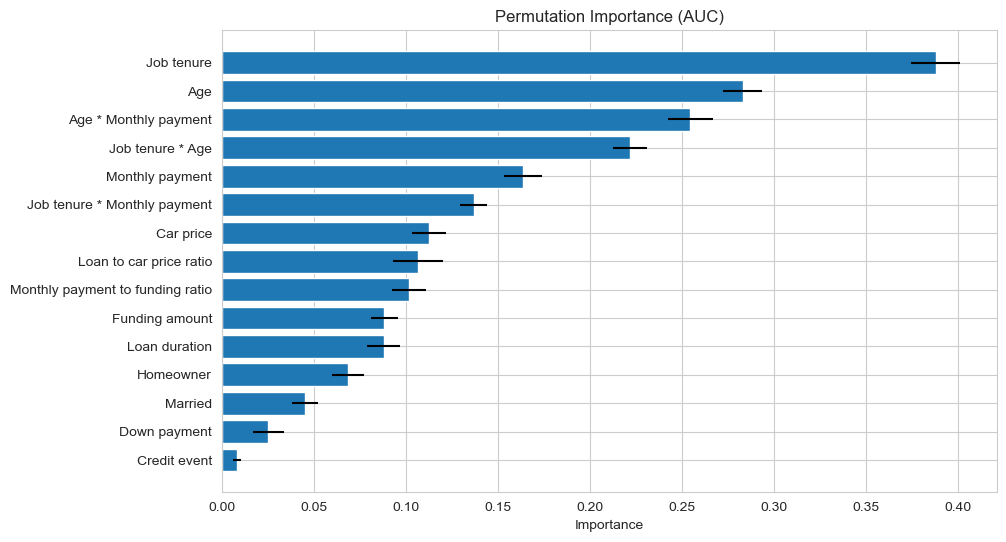

In [40]:
df = pd.read_csv("../Data/black_box_3_data.csv")

X = df.drop(columns=["Default (y)", "Pred_default (y_hat)", "PD", "Group"])

y = df["Default (y)"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Perform permutation importance on the test set
perm_importance = permutation_importance(
    best_pipeline, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=42
)

# Get feature importances and their standard deviations
importance_means = perm_importance.importances_mean
importance_std = perm_importance.importances_std
X.rename(
    columns={"Monthly payment to income ratio": "Monthly payment to funding ratio"},
    inplace=True,
)
features = np.array(X.columns)

# Sort by importance in descending order
indices = np.argsort(importance_means)[::-1]  # Sort in descending order

# Plot the results
plt.figure(figsize=(10, 6))
plt.title("Permutation Importance (AUC)")
plt.barh(
    range(len(indices)),
    importance_means[indices],
    xerr=importance_std[indices],
    align="center",
)
plt.yticks(range(len(indices)), features[indices])
plt.gca().invert_yaxis()  # Ensures the most important feature is at the top
plt.xlabel("Importance")
plt.show()


### Comparison of SHAP Values and Permutation Importance

Both the SHAP plot and the Permutation Importance plot you generated provide insights into feature importance, but they offer different perspectives on how the model interprets features.

 1. SHAP Summary Plot (Feature Impact on Predictions):
- **Purpose**: SHAP explains the contribution of each feature to individual predictions.
- **Interpretation**: It measures the average impact of a feature on the model’s output (i.e., how much the feature drives the prediction towards a certain class).

#### Key Insights:
- **Job tenure, Job tenure * Age, and Age** have the highest SHAP values, meaning they significantly influence individual predictions. These features have the most substantial effect on shifting the model's output either towards or away from predicting a loan default.
- **Interaction terms** like *Job tenure * Age* and *Age * Monthly payment* are also critical, showing how these combined features impact predictions.
- **Credit event** and **Down payment** have relatively little influence on individual predictions, as indicated by their near-zero SHAP values.

2. Permutation Importance (Feature Impact on Model Performance):
- **Purpose**: Permutation Importance measures the effect of randomly shuffling a feature’s values on the overall model performance (AUC in this case). It identifies which features are critical to maintaining the model’s predictive accuracy.
- **Interpretation**: This metric shows how much the performance metric (AUC) drops when a feature is permuted (shuffled).

#### Key Insights:
- **Job tenure** and **Age** remain the most critical features, showing the largest drop in AUC when shuffled. This consistency suggests that these features not only affect individual predictions (as seen in SHAP) but are also central to the model’s overall predictive ability.
- Interaction terms like **Age * Monthly payment** and **Job tenure * Age** still have a substantial impact, though **Monthly payment** itself ranks higher than in the SHAP plot.
- **Credit event** and **Down payment** have the least importance, as shuffling these features barely impacts the model’s performance.

#### Similarities:
- Both methods rank **Job tenure** and **Age** as highly important features.
- Interaction terms such as **Job tenure * Age** and **Age * Monthly payment** also feature prominently in both plots, showing that the interactions between these features are important for both individual predictions and overall model performance.

#### Differences:
- **Monthly payment** is more important in the Permutation Importance plot than in the SHAP plot. This suggests that while the Monthly payment feature does not drastically shift individual predictions, the model relies heavily on it for overall performance.
- **Credit event** and **Down payment** are shown to have little influence in both, but their impact is even lower in the SHAP plot, indicating that these features hardly affect individual predictions.

#### Conclusion:
- **Key Drivers**: Both methods identify **Job tenure** and **Age** as the primary drivers of the model’s predictive power.
- **Feature Interactions**: The SHAP plot highlights interaction terms (e.g., *Job tenure * Age*), showing their critical role in individual predictions, while the Permutation Importance plot emphasizes the features that maintain the overall model’s predictive accuracy.

Using both methods provides a more comprehensive understanding of how the model works, balancing insights into individual-level impacts (SHAP) and model-wide performance contributions (Permutation Importance).


# Exercise 09:
## Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity

In [41]:
df = pd.read_csv("../Data/black_box_3_data.csv")

## Statistical Parity

In [42]:
# Group age into categories (for simplicity, we'll create 3 age groups)
df["Age_group"] = pd.cut(
    df["Age"], bins=[18, 30, 50, np.inf], labels=["18-30", "31-50", "51+"]
)

# Create a contingency table for Age_group and predicted default (y_hat)
stat_parity_table = pd.crosstab(df["Age_group"], df["Pred_default (y_hat)"])

# Perform the Chi-squared test for Statistical Parity
chi2_stat_parity, p_val_parity, dof_parity, ex_parity = chi2_contingency(
    stat_parity_table
)

# Results output
print(
    f"Statistical Parity Test: Chi-squared = {chi2_stat_parity}, p-value = {p_val_parity}"
)


Statistical Parity Test: Chi-squared = 275.9681041369713, p-value = 1.1865542412133135e-60


## Conditional Statistical Parity

In [43]:
# Iterate over each group in the 'Group' column
cond_stat_parity_results = {}
for group in df["Group"].unique():
    group_data = df[df["Group"] == group]
    cond_table = pd.crosstab(
        group_data["Age_group"], group_data["Pred_default (y_hat)"]
    )

    # Perform the Chi-squared test for each group
    chi2, p_val, dof, ex = chi2_contingency(cond_table)
    cond_stat_parity_results[group] = (chi2, p_val, dof)

# Results output
for group, (chi2, p_val, dof) in cond_stat_parity_results.items():
    print(
        f"Conditional Statistical Parity Test for Group {group}: Chi-squared = {chi2}, p-value = {p_val}"
    )


Conditional Statistical Parity Test for Group 1: Chi-squared = 6.808326942055404, p-value = 0.03323461017105395
Conditional Statistical Parity Test for Group 0: Chi-squared = 111.37992071758009, p-value = 6.518647827830717e-25


1. Statistical Parity Test
- **Chi-squared**: 275.97
- **p-value**: 1.19e-60  
Since the p-value is significantly smaller than the standard significance threshold (e.g., 0.05), we reject the null hypothesis. This indicates that the predicted default outcomes (y_hat) are not independent of age.

2. Conditional Statistical Parity Test
- **Group 1**: 
  - **Chi-squared**: 6.81 
  - **p-value**: 0.033  
  The p-value is below 0.05, so we reject the null hypothesis. This suggests that even within Group 1, the model's predictions are not independent of age. Conditional on belonging to Group 1, there is still a disparity in predictions based on age.
  
- **Group 0**: 
  - **Chi-squared**: 111.38 
  - **p-value**: 6.52e-25  
  The p-value is extremely small, meaning we also reject the null hypothesis for Group 0. Predictions are highly dependent on age even within this group.

Overall Assessment of Fairness
- **Statistical Parity**: The test strongly suggests that the model is not fair concerning age. Predictions are significantly influenced by the age of the borrowers, indicating that younger or older individuals may be more likely to be classified as defaulting.

- **Conditional Statistical Parity**: The bias related to age persists even when controlling for the variable Group. Both groups exhibit dependency on age, which violates conditional statistical parity. This indicates that the predictions remain unfair within each group.


# Exercise 10:
## Implement a FPDP using a fairness measure

In [44]:
df = pd.read_csv("../Data/black_box_3_data.csv")


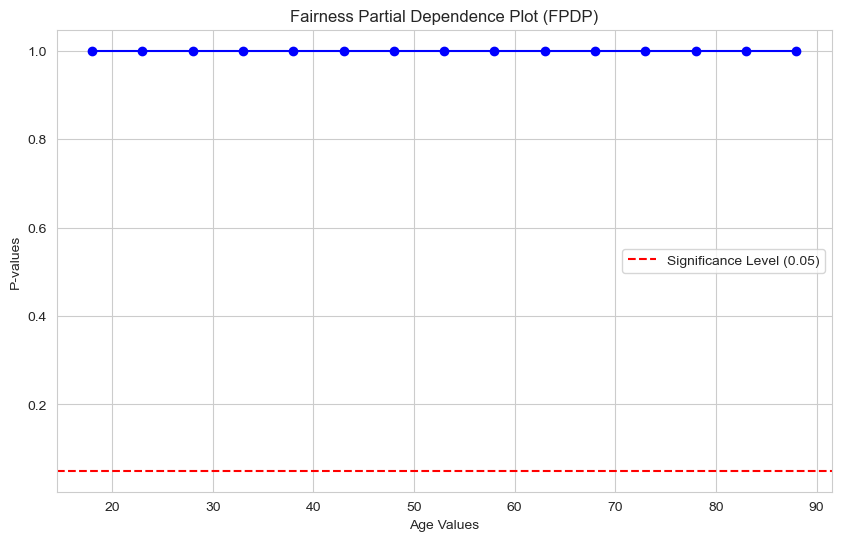

In [45]:
# Set age values to test and initialize an empty list for p-values
age_values = list(range(18, 89, 5))
p_values = []

# Iterate over the age values to generate the FPDP
for age in age_values:
    # Create a copy of the dataframe and set all 'Age' values to the current age value in the iteration
    df_temp = df.copy()
    df_temp["Age"] = age

    # Create contingency table for the chi-square test
    # y_hat represents Pred_default, and D represents Age
    contingency_table = pd.crosstab(df_temp["Pred_default (y_hat)"], df_temp["Age"])

    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Append the p-value to the list
    p_values.append(p)

# Plotting the Fairness Partial Dependence Plot (FPDP)
plt.figure(figsize=(10, 6))
plt.plot(age_values, p_values, marker="o", linestyle="-", color="b")
plt.xlabel("Age Values")
plt.ylabel("P-values")
plt.title("Fairness Partial Dependence Plot (FPDP)")
plt.axhline(0.05, color="red", linestyle="--", label="Significance Level (0.05)")
plt.legend()
plt.grid(True)
plt.show()


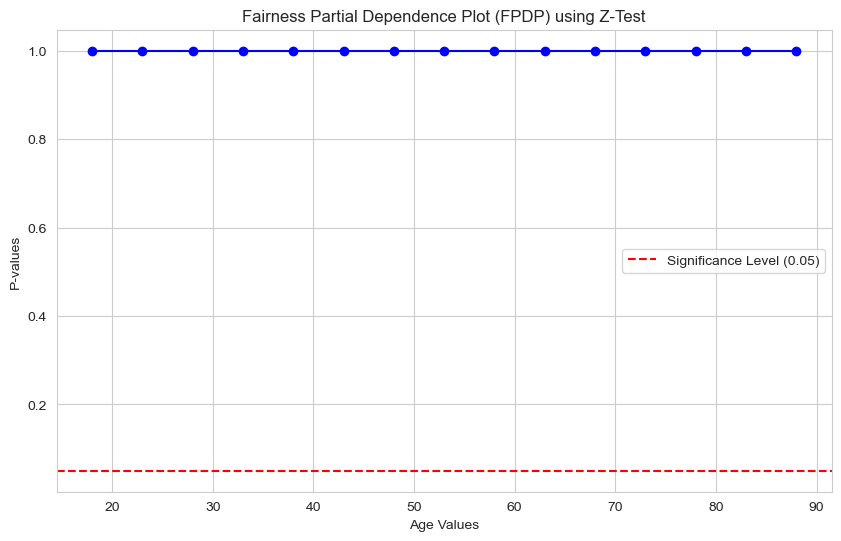

In [46]:
age_values = list(range(18, 89, 5))
p_values = []

# Calculate the overall proportion of 'Pred_default (y_hat)' being 1
overall_p = df["Pred_default (y_hat)"].mean()
n = len(df)

# Iterate over the age values to generate the FPDP
for age in age_values:
    # Create a copy of the dataframe and set all 'Age' values to the current age value in the iteration
    df_temp = df.copy()
    df_temp["Age"] = age

    # Calculate the observed proportion for the modified dataset
    p_hat = df_temp["Pred_default (y_hat)"].mean()

    # Calculate the z-score
    z_score = (p_hat - overall_p) / np.sqrt(overall_p * (1 - overall_p) / n)

    # Calculate the p-value for a two-sided test
    p_value = 2 * norm.sf(abs(z_score))

    # Append the p-value to the list
    p_values.append(p_value)

# Plotting the Fairness Partial Dependence Plot (FPDP)
plt.figure(figsize=(10, 6))
plt.plot(age_values, p_values, marker="o", linestyle="-", color="b")
plt.xlabel("Age Values")
plt.ylabel("P-values")
plt.title("Fairness Partial Dependence Plot (FPDP) using Z-Test")
plt.axhline(0.05, color="red", linestyle="--", label="Significance Level (0.05)")
plt.legend()
plt.grid(True)
plt.show()
